Import the CSV dataset on movies from Kaggle website into pandas dataframe called 'movies_raw' and select relevant columns for input features and genre prediction model. Create a new data frame (called 'movies') to store dataset with modifications.

In [1]:
import pandas as pd
import numpy as np

cols_to_use = ['title','status','genres','production_countries',
                                            'release_date','runtime','popularity', 'vote_average', 'vote_count', 'revenue', 'budget']

movies_raw = pd.read_csv('movies.csv', usecols=cols_to_use, low_memory=False)[cols_to_use]

movies = movies_raw

movies.head()

,title,status,genres,production_countries,release_date,runtime,popularity,vote_average,vote_count,revenue,budget
0,Toy Story,Released,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/30/1995,81.0,21.946943,7.7,5415.0,373554033.0,30000000
1,Jumanji,Released,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/15/1995,104.0,17.015539,6.9,2413.0,262797249.0,65000000
2,Grumpier Old Men,Released,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,101.0,11.7129,6.5,92.0,0.0,0
3,Waiting to Exhale,Released,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",12/22/1995,127.0,3.859495,6.1,34.0,81452156.0,16000000
4,Father of the Bride Part II,Released,"[{'id': 35, 'name': 'Comedy'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2/10/1995,106.0,8.387519,5.7,173.0,76578911.0,0


Also import Excel spreadsheet table as dataframe which gives information on revenue and budget averages by genre. 
This information will be used during the preprocessing step.

In [2]:
genre_avg = pd.read_excel('Averages.xlsx', skiprows=2)



genre_avg.head()


,Unnamed: 0,Genre,Revenue,Budget
0,NaN,Fantasy,78645440.0,26304140.0
1,NaN,Romance,18961540.0,6472397.0
2,NaN,War,23051070.0,10254710.0
3,NaN,Western,6428505.0,3798215.0
4,NaN,Action,50434380.0,19311490.0


## Part 1: Data Preprocessing

Some data manipulation/cleaning is required to remove nonsense or nonapplicable records as well as to get the specific cross-section of the data we need in the proper format for our analysis. 

### Removing N/A Records and Fixing Data Types

First, filter out rows which have "NA" or null values in any of the columns in the movies dataframe.

In [3]:
for column in movies:
    movies = movies.loc[(movies[column].isna()==False) & (movies[column].isnull()==False)]

Also, filter out rows where "genre" or "production company" is blank, i.e. "[]":

In [4]:
movies = movies.loc[(movies['genres']!='[]')]

Next, convert the non-string columns to their appropriate data types.

In [5]:
movies.runtime = movies.runtime.astype(int)
movies.vote_average = movies.vote_average.astype(float)
movies.vote_count = movies.vote_count.astype(int)
movies.release_date = pd.to_datetime(movies.release_date)
movies.popularity = movies.popularity.astype(float)
movies.revenue = movies.revenue.astype(int)
movies.budget = movies.budget.astype(int)

Next, filter on only movies that were actually released (not cancelled, postponed, etc). 

In [6]:
movies = movies.loc[(movies['status']=='Released')]

Next, filter out movies that were not produced (at least in part) in the United States, since our focus is on the popularity of specific movie genres in the domestic (U.S.) market.

In [7]:
movies = movies.loc[movies['production_countries'].str.contains('United States')==True]

In [8]:
movies.head()

,title,status,genres,production_countries,release_date,runtime,popularity,vote_average,vote_count,revenue,budget
0,Toy Story,Released,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81,21.946943,7.7,5415,373554033,30000000
1,Jumanji,Released,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104,17.015539,6.9,2413,262797249,65000000
2,Grumpier Old Men,Released,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101,11.712900,6.5,92,0,0
3,Waiting to Exhale,Released,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127,3.859495,6.1,34,81452156,16000000
4,Father of the Bride Part II,Released,"[{'id': 35, 'name': 'Comedy'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106,8.387519,5.7,173,76578911,0


### Creating One-Hot Encoded Vectors for Movie Genres

The final step in formatting data columns is to convert the "genre" field (which is currently in a data dictionary list format) into encoded binary feature vectors (i.e. 0 or 1) for each genre to indicate whether a particular movie belongs to that genre. For example, a movie that is an "action/comedy", the genres "Action" and "Comedy" will have values of 1, and all other genre variables will be 0:

In [9]:
# convert "genre" data dictionary list field (from Kaggle) into to a list of lists, 
# where each element equals to the list of all applicable genres for a certain movie. 

import ast

genres = pd.DataFrame.from_dict(movies.genres)

def remove_bracket(list1):
    return str(list1).replace('["','').replace(']"','')

genres_dict = dict()

for i in range(len(genres)):
    genres_dict[i] = ast.literal_eval(remove_bracket(list(genres.iloc[i])))
    
genres_list = list()

for i in range(0,len(genres_dict)):
    temp_list = list()
    for j in range(0, len(genres_dict[i])):
        temp_list.append(genres_dict[i][j]['name'])
    genres_list.append(temp_list)

# Print genre list for first four movies in dataset for demonstration:
print(genres_list[0:4])


[['Animation', 'Comedy', 'Family'], ['Adventure', 'Fantasy', 'Family'], ['Romance', 'Comedy'], ['Comedy', 'Drama', 'Romance']]


In [10]:
# determine all the unique genre names in list for entire dataset

merged_genres_list = list()

for i in range(0,len(genres_list)):
    merged_genres_list = merged_genres_list + genres_list[i]
    
# display full list of unique genres from dataset
unique_genres_list = list(set(merged_genres_list))

# create new list specifically for using as column names in df
unique_genres_list_df = unique_genres_list.copy()

# replace spaces with underscores in genre name for df columns
for i in range(0, len(unique_genres_list_df)):
    col_name = "genre_"+ unique_genres_list_df[i].lower().replace(" ","_")
    unique_genres_list_df[i] = col_name
    
print(unique_genres_list)
    

['Documentary', 'Foreign', 'Music', 'Animation', 'Thriller', 'Western', 'Comedy', 'Crime', 'War', 'Fantasy', 'TV Movie', 'History', 'Drama', 'Romance', 'Action', 'Horror', 'Adventure', 'Family', 'Mystery', 'Science Fiction']


In [11]:
# Add a new binary column (yes/no) for each unique genre to the movies dataframe
# For each data point, specify whether genre applies to that movie/record

# binary variable that indicates whether a particular movie is of a certian genre
in_list = 0


for i in range(0, len(unique_genres_list_df)):
    # Placeholder arrray to store full set of binary values (true/false) to write to df column
    genre_match = []
    for j in range(0,len(genres_list)):
        if (unique_genres_list[i] in genres_list[j]):
            in_list = 1
        else:
            in_list = 0
        genre_match.append(in_list)
    movies[unique_genres_list_df[i]] = genre_match


# List of all columns in movies dataset after addition of new columns to df
list(movies.columns.values)

['title',
 'status',
 'genres',
 'production_countries',
 'release_date',
 'runtime',
 'popularity',
 'vote_average',
 'vote_count',
 'revenue',
 'budget',
 'genre_documentary',
 'genre_foreign',
 'genre_music',
 'genre_animation',
 'genre_thriller',
 'genre_western',
 'genre_comedy',
 'genre_crime',
 'genre_war',
 'genre_fantasy',
 'genre_tv_movie',
 'genre_history',
 'genre_drama',
 'genre_romance',
 'genre_action',
 'genre_horror',
 'genre_adventure',
 'genre_family',
 'genre_mystery',
 'genre_science_fiction']

To finish up the data formatting portion, will drop the columns in the movies dataframe that are no longer needed - i.e. the original "genre" field, as well as other fields that were used only for filtering (e.g. status, production_countries, etc).

In [12]:
movies = movies.drop(columns=['status','genres','production_countries'])

In [13]:
# add column which lists all of each movie's genres

movies['gen_list'] = genres_list

movies.tail()

,title,release_date,runtime,popularity,vote_average,vote_count,revenue,budget,genre_documentary,genre_foreign,...,genre_history,genre_drama,genre_romance,genre_action,genre_horror,genre_adventure,genre_family,genre_mystery,genre_science_fiction,gen_list
45456,House of Horrors,1946-03-29,65,0.222814,6.3,8,0,0,0,0,...,0,0,0,0,1,0,0,1,0,"[Horror, Mystery, Thriller]"
45458,The Burkittsville 7,2000-10-03,30,0.386450,7.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,[Horror]
45459,Caged Heat 3000,1995-01-01,85,0.661558,3.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[Science Fiction]
45460,Robin Hood,1991-05-13,104,5.683753,5.7,26,0,0,0,0,...,0,1,1,1,0,0,0,0,0,"[Drama, Action, Romance]"
45463,Betrayal,2003-08-01,90,0.903007,3.8,6,0,0,0,0,...,0,1,0,1,0,0,0,0,0,"[Action, Drama, Thriller]"


### Substitutions for Missing "Revenue" or "Budget" Data

Loop through each record in the "movies" dataset, and fill in those that have either missing "Revenue" or "Budget" field (i.e. equals zero) to the average for that genre (contained in genre_avg dataframe). Eliminate records missing both fields. Also, add an additional "Substitution" column that indicates whether a given record had a substitution for revenue/budget (1=Substitution, 2=No substitution).

In [14]:
genre_revenue_avg = []
genre_budget_avg = []


In [15]:
movies = movies.loc[(movies['revenue']!=0) | (movies['budget']!=0)]

In [16]:
sum_revenue = 0
sum_budget = 0

In [17]:

for i in range(0, len(movies)):
    genre_revenue_avg.append(genre_avg.loc[genre_avg['Genre'].isin(genres_list[i])]['Revenue'].mean())
    genre_budget_avg.append(genre_avg.loc[genre_avg['Genre'].isin(genres_list[i])]['Budget'].mean())
    
# add combined mean genre revenues and budgets to data frame

movies['revenue_avg'] = genre_revenue_avg
movies['budget_avg'] = genre_budget_avg

In [18]:
# where revenue = 0, substitute average revenue
# where budget = 0, substitute average budget
# create a substitutions column with binary indicator (0/1)

revenue = []
budget = []
substitution = []

# Flag that turns on/off substitutions
substitute_ind = True;

for i in range(0, len(movies)):
    if substitute_ind == False:
        budget.append(movies.iloc[i].budget)
        revenue.append(movies.iloc[i].revenue)
        substitution.append(0)
        continue
    if movies.iloc[i].revenue == 0:
        revenue.append(movies.iloc[i].revenue_avg)
        budget.append(movies.iloc[i].budget)
        substitution.append(1)
        continue
    if movies.iloc[i].budget == 0:
        budget.append(movies.iloc[i].budget_avg)
        revenue.append(movies.iloc[i].revenue)
        substitution.append(1)
        continue
    else:
        budget.append(movies.iloc[i].budget)
        revenue.append(movies.iloc[i].revenue)
        substitution.append(0)
        
movies['revenue'] = revenue
movies['budget'] = budget  
movies['substitution'] = substitution


In [19]:
movies.head()

,title,release_date,runtime,popularity,vote_average,vote_count,revenue,budget,genre_documentary,genre_foreign,...,genre_action,genre_horror,genre_adventure,genre_family,genre_mystery,genre_science_fiction,gen_list,revenue_avg,budget_avg,substitution
0,Toy Story,1995-10-30,81,21.946943,7.7,5415,373554033.0,3.000000e+07,0,0,...,0,0,0,1,0,0,"[Animation, Comedy, Family]",46703445.0,1.409114e+07,0
1,Jumanji,1995-12-15,104,17.015539,6.9,2413,262797249.0,6.500000e+07,0,0,...,0,0,1,1,0,0,"[Adventure, Fantasy, Family]",83654700.0,2.754374e+07,0
3,Waiting to Exhale,1995-12-22,127,3.859495,6.1,34,81452156.0,1.600000e+07,0,0,...,0,0,0,0,0,0,"[Comedy, Drama, Romance]",20854425.0,7.266428e+06,0
4,Father of the Bride Part II,1995-02-10,106,8.387519,5.7,173,76578911.0,7.072526e+06,0,0,...,0,0,0,0,0,0,[Comedy],19288380.0,7.072526e+06,1
5,Heat,1995-12-15,170,17.924927,7.7,1886,187436818.0,6.000000e+07,0,0,...,1,0,0,0,0,0,"[Action, Crime, Drama, Thriller]",22747310.0,8.060459e+06,0


### Adding in ROI Percent ("Popularity") Metric

In [20]:
movies['ROI_perc'] = 100 * ((movies['revenue']/movies['budget'])-1)

In [21]:
# Sort by most popular movies, display first 5 rows of modified movies dataset

movies = movies.sort_values(by=['release_date'])

# Add column for release month/year
import time

movies['MonthYear'] = movies['release_date'].dt.strftime('%b %Y')
movies['Month'] = movies['release_date'].dt.strftime('%b')
movies['Year'] = movies['release_date'].dt.strftime('%Y')

movies.head()

,title,release_date,runtime,popularity,vote_average,vote_count,revenue,budget,genre_documentary,genre_foreign,...,genre_mystery,genre_science_fiction,gen_list,revenue_avg,budget_avg,substitution,ROI_perc,MonthYear,Month,Year
11423,The Great Train Robbery,1903-12-01,12,4.248169,7.1,116,17558915.0,150.0,0,0,...,0,0,"[Action, Adventure, Western]",17558915.0,6578559.00,1,1.170584e+07,Dec 1903,Dec,1903
32320,The Dinosaur and the Missing Link: A Prehistor...,1915-01-01,5,0.176389,5.5,2,28465400.0,5000.0,0,0,...,0,0,"[Animation, Comedy]",28465400.0,11841480.00,1,5.692080e+05,Jan 1915,Jan,1915
6913,The Birth of a Nation,1915-02-08,193,5.113205,6.4,109,11000000.0,100000.0,0,0,...,0,0,"[Drama, History, War]",34127645.0,11880429.25,0,1.090000e+04,Feb 1915,Feb,1915
33057,Carmen,1915-10-31,59,0.224472,6.3,4,19603680.0,23430.0,0,0,...,0,0,[Drama],19603680.0,8469715.50,1,8.356914e+04,Oct 1915,Oct,1915
8293,The Cheat,1915-12-13,59,0.680407,4.8,11,137365.0,17311.0,0,0,...,0,0,[Drama],41624200.0,9238404.50,0,6.935128e+02,Dec 1915,Dec,1915


### Summarizing Dataset as Time-Series

Next, we will summarize the movies dataset in a slightly different way. In order to assess which genres are trending in popularity over time, we need to create a genre popularity index time series aggregated by month (for each genre). For example, the "Comedy" time series will be the aggregated monthly average popularity rating for all "Comedy" genre movies from 1980-2017. This way, we can visualize how different genres are performing at different times.

First, we subset the movies dataframe for each genre (i.e. genre_X = 1) and create the aggregate mean popularity of that genre by month.

In [22]:
# create list of column names in movies dataset containing genre binary variables

dataset_genre_columns = list()

for i in range(0, len(unique_genres_list)):
        dataset_genre_columns.append("genre_" + unique_genres_list[i].lower().replace(" ","_"))
        
#  create subset of movies dataset for each genre

subset_list = list()

for i in range(0, len(dataset_genre_columns)):
    subset_name = "movies_" + dataset_genre_columns[i]
    subset_list.append(movies.loc[movies[dataset_genre_columns[i]]==1])
    
#  create new time series dataset where the identifier is Month-Year (e.g. "Jun 2007")
#  merge all average genre popularity variables into one dataset

ts_genre_pop = pd.DataFrame({'Month': np.asarray(movies['MonthYear'])})

for i in range(0, len(subset_list)):
    series = subset_list[i]['ROI_perc'].groupby(movies['MonthYear'], sort=False).mean()
    series_df = pd.DataFrame({'Month':series.index, 'ROI':series.values})
    ts_genre_pop = pd.merge(ts_genre_pop, series_df, on='Month', how='outer')
    ts_genre_pop = ts_genre_pop.drop_duplicates()

# set month as index variable and rename columns appropriately

ts_genre_pop.set_index('Month')

ts_genre_pop.columns.values[1:] = np.asarray(dataset_genre_columns)
    
# make copy of dataset with entire time range (1898-2017) and create subset with only Jan 1987 and onwards

# extract date as datetime object series from dataset

mmyyyy = []

from datetime import datetime

for i in range(0, len(ts_genre_pop)):
        mmyyyy.append(datetime.strptime(ts_genre_pop['Month'][i],'%b %Y'))

ts_genre_pop['mmyyyy'] = mmyyyy

ts_genre_pop = ts_genre_pop.loc[(ts_genre_pop['mmyyyy'] >= 'Jan 1980')]


Glimpse of what the new dataset looks like:

In [23]:
ts_genre_pop.head()

,Month,genre_documentary,genre_foreign,genre_music,genre_animation,genre_thriller,genre_western,genre_comedy,genre_crime,genre_war,...,genre_history,genre_drama,genre_romance,genre_action,genre_horror,genre_adventure,genre_family,genre_mystery,genre_science_fiction,mmyyyy
459,Jan 1980,NaN,NaN,NaN,-72.294599,-22.861852,NaN,-72.294599,-22.861852,NaN,...,NaN,NaN,NaN,168.536508,NaN,NaN,-72.294599,NaN,168.536508,1980-01-01
460,Feb 1980,NaN,NaN,NaN,NaN,192.194195,NaN,32.090384,373.826542,NaN,...,NaN,138.826258,373.826542,32.090384,2037.836100,NaN,NaN,NaN,NaN,1980-02-01
461,Mar 1980,NaN,NaN,347.885247,NaN,-81.180060,NaN,-24.801437,NaN,NaN,...,NaN,80.634583,-24.801437,-81.180060,8998.924000,-81.180060,-24.801437,NaN,NaN,1980-03-01
462,Apr 1980,NaN,NaN,NaN,NaN,-65.353507,NaN,1.228506,NaN,NaN,...,NaN,1.228506,NaN,NaN,-65.353507,NaN,NaN,NaN,-65.353507,1980-04-01
463,May 1980,NaN,NaN,NaN,NaN,131.670389,57.95189,300.000000,NaN,60.138222,...,57.95189,92.836374,NaN,2891.111111,5448.071649,2891.111111,NaN,NaN,2891.111111,1980-05-01


### Converting to Classification Dataset (i.e. "highest ROI class" by month)

We also need the dataset to be summarized in a way that tells us which <i>genre</i> is on top in a given month and year based on the ROI metric. So in the following steps, we are converting the above time series dataset from one that tells us average ROI percent for each genre in a given month to one that indicates <i>which genre has the highest ROI in a given month</i>.

In [24]:
ts_genre_class = ts_genre_pop

# Strip columns with date format to apply max column (idxmax) function

ts_genre_class = ts_genre_class.drop(columns=['Month','mmyyyy'])

ts_genre_pop['Top Genre'] = ts_genre_class.idxmax(axis=1, skipna=True)

In [25]:
# remove 'genre_' from column name

Top_Genre = []

for i in range(0, len(ts_genre_pop)):
    if (ts_genre_pop['Top Genre'].iloc[i]=='genre_science_fiction'):
        Top_Genre.append('science fiction')
    else:
        Top_Genre.append(ts_genre_pop['Top Genre'].iloc[i][6:])
    

In [26]:
ts_genre_pop['Top Genre'] = Top_Genre

ts_genre_pop.head(5)

,Month,genre_documentary,genre_foreign,genre_music,genre_animation,genre_thriller,genre_western,genre_comedy,genre_crime,genre_war,...,genre_drama,genre_romance,genre_action,genre_horror,genre_adventure,genre_family,genre_mystery,genre_science_fiction,mmyyyy,Top Genre
459,Jan 1980,NaN,NaN,NaN,-72.294599,-22.861852,NaN,-72.294599,-22.861852,NaN,...,NaN,NaN,168.536508,NaN,NaN,-72.294599,NaN,168.536508,1980-01-01,action
460,Feb 1980,NaN,NaN,NaN,NaN,192.194195,NaN,32.090384,373.826542,NaN,...,138.826258,373.826542,32.090384,2037.836100,NaN,NaN,NaN,NaN,1980-02-01,horror
461,Mar 1980,NaN,NaN,347.885247,NaN,-81.180060,NaN,-24.801437,NaN,NaN,...,80.634583,-24.801437,-81.180060,8998.924000,-81.180060,-24.801437,NaN,NaN,1980-03-01,horror
462,Apr 1980,NaN,NaN,NaN,NaN,-65.353507,NaN,1.228506,NaN,NaN,...,1.228506,NaN,NaN,-65.353507,NaN,NaN,NaN,-65.353507,1980-04-01,comedy
463,May 1980,NaN,NaN,NaN,NaN,131.670389,57.95189,300.000000,NaN,60.138222,...,92.836374,NaN,2891.111111,5448.071649,2891.111111,NaN,NaN,2891.111111,1980-05-01,horror


## Part 2: Data Exploratory Analysis and Modifications

### Visually Checking Data Distribution by Year

At this point, we need to look at the distribution of release dates for movies in our modified dataset to decide on the appropriate cut-off. Of course, more training examples is better, but at the same time, we don't want to include time ranges where the data is too sparse (e.g. only a handful of movies produced that year). Look at a histogram to understand the distribution of movies' release years in our dataset:

In [27]:
import matplotlib.pyplot as plt 

ax = movies['release_date'].groupby(movies['release_date'].dt.year).count().plot(kind='bar', figsize=(30, 10), color='blue')
ax.set_xlabel("Release Year", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Movie Count by Year in 'Movies' Dataset", fontsize=18)

Text(0.5,1,"Movie Count by Year in 'Movies' Dataset")

From a first glance at the above histogram, the data pre-1987 release date may be considered to be "sparse".

However, we must also consider the distribution of movie genres by time period for a given level of granularity (e.g. by month). There must be sufficient representation of each genre over a certain time period in order to assess the relative popularity of genres correctly during that time. For example, if no action movies were released for several months in 1987, we cannot say whether or not action movies were trending at that time.

The following chart shows how different genres of movies were represented between 1987 - 2017, based on the yearly average count of each genre during that 30-year period.

In [28]:
import numpy as np

genre_avg_counts = list()

# subset movies dataframe for time period 1987 onwards
movies_subset = movies.loc[movies.release_date > '1987-01-01']

for i in range(0,len(unique_genres_list)):
    genre_avg_counts.append(np.mean(movies_subset[unique_genres_list_df[i]].groupby(movies_subset['release_date'].dt.year).sum()))
    
# create dataframe with genre name and average counts 

genre_avg_counts_df = pd.DataFrame({'Genre': unique_genres_list, 'Yearly Average Count (1980-2017)': genre_avg_counts})

genre_avg_counts_df.sort_values(by=['Yearly Average Count (1980-2017)'], ascending=False)



,Genre,Yearly Average Count (1980-2017)
12,Drama,88.322581
6,Comedy,70.483871
4,Thriller,56.967742
14,Action,47.354839
13,Romance,34.129032
7,Crime,29.161290
16,Adventure,28.193548
15,Horror,26.129032
19,Science Fiction,21.838710
17,Family,19.612903


### Combining Low Frequency Genres into "Other" Category

The above ordered list suggests that we should combine all genres after a certain point into an "Other" category. We have decided the cutoff should be after <b>Horror</b> films. All subsequent genres will be rolled up into an "Other" genre class.

In [29]:
# collect names of top 10 highest average yearly count genres in the form of a list

main_genres = genre_avg_counts_df.sort_values(by=['Yearly Average Count (1980-2017)'], ascending=False)['Genre'][0:10]

list(main_genres)

for i in range(0,len(main_genres)):
    main_genres.iloc[i] = main_genres.iloc[i].lower()
    
main_genres = list(main_genres)

main_genres

['drama',
 'comedy',
 'thriller',
 'action',
 'romance',
 'crime',
 'adventure',
 'horror',
 'science fiction',
 'family']

This means we need to go back to the "movies" dataset and rename all columns not related to the above 10 genres to an "Other"
column and process into a time series dataset once more. Also need to recreate "highest ROI class" dataset. Repeating all relevant previous steps from part 1 here with "Other" genre substitution:

In [30]:
# Make copy of "movies" dataset and rename every genre binary variable not in above list to "other":

movies_new = movies.copy()

new_title = []

for i in range(0,len(movies_new.columns)):
    if 'genre' in movies_new.columns[i]:
        genre_name = movies_new.columns[i][6:]
        genre_name = genre_name.replace('_',' ')
        if genre_name not in main_genres:
            new_title.append("other")
        else:
            new_title.append(movies_new.columns[i])
    else:
        new_title.append(movies_new.columns[i])
        
movies_new.columns = new_title

movies_new['other'].head()

,other,other,other,other,other,other,other,other,other,other
11423,0,0,0,0,1,0,0,0,0,0
32320,0,0,0,1,0,0,0,0,0,0
6913,0,0,0,0,0,1,0,0,1,0
33057,0,0,0,0,0,0,0,0,0,0
8293,0,0,0,0,0,0,0,0,0,0


In [31]:
# combine all "other" columns into a single "genre_other" indicator column
# drop all "other" columns

movies_new['genre_other'] = movies_new['other'].max(axis=1)

movies_new = movies_new.drop(columns=['other'])

In [32]:
# reorder columns appropriately

movies_new = movies_new[['title', 'release_date','MonthYear','Month','Year','runtime','popularity','vote_average',
                        'vote_count','revenue','budget','genre_romance','genre_action','genre_thriller','genre_horror',
                        'genre_drama','genre_family','genre_adventure','genre_science_fiction','genre_crime','genre_comedy',
                        'genre_other','revenue_avg','budget_avg','substitution','ROI_perc']]

# change unique genres list to only include main genres (10) and 'other'

unique_genres_list = main_genres.copy()

unique_genres_list.append('other')

unique_genres_list

['drama',
 'comedy',
 'thriller',
 'action',
 'romance',
 'crime',
 'adventure',
 'horror',
 'science fiction',
 'family',
 'other']

Below, we will repeat the previous steps done in Part 1 to create a genre popularity (average ROI percentage by month index) time series dataset with the "genre_other" category.

In [33]:
# set movies dataset to modified 'movies_new' version

movies = movies_new.copy()

# create list of column names in movies dataset containing genre binary variables

dataset_genre_columns = list()

for i in range(0, len(unique_genres_list)):
        dataset_genre_columns.append("genre_" + unique_genres_list[i].lower().replace(" ","_"))
        
#  create subset of movies dataset for each genre

subset_list = list()

for i in range(0, len(dataset_genre_columns)):
    subset_name = "movies_" + dataset_genre_columns[i]
    subset_list.append(movies.loc[movies[dataset_genre_columns[i]]==1])
    
#  create new time series dataset where the identifier is Month-Year (e.g. "Jun 2007")
#  merge all average genre popularity variables into one dataset

ts_genre_pop = pd.DataFrame({'Month': np.asarray(movies['MonthYear'])})

for i in range(0, len(subset_list)):
    series = subset_list[i]['ROI_perc'].groupby(movies['MonthYear'], sort=False).mean()
    series_df = pd.DataFrame({'Month':series.index, 'ROI':series.values})
    ts_genre_pop = pd.merge(ts_genre_pop, series_df, on='Month', how='outer')
    ts_genre_pop = ts_genre_pop.drop_duplicates()

# set month as index variable and rename columns appropriately

ts_genre_pop.set_index('Month')

ts_genre_pop.columns.values[1:] = np.asarray(dataset_genre_columns)
    
# make copy of dataset with entire time range (1898-2017) and create subset with only Jan 1987 and onwards

# extract date as datetime object series from dataset

mmyyyy = []

from datetime import datetime

for i in range(0, len(ts_genre_pop)):
        mmyyyy.append(datetime.strptime(ts_genre_pop['Month'][i],'%b %Y'))

ts_genre_pop['mmyyyy'] = mmyyyy

ts_genre_pop = ts_genre_pop.loc[(ts_genre_pop['mmyyyy'] >= 'Jan 1980')]

ts_genre_pop.head()


,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,genre_family,genre_other,mmyyyy
459,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,-72.294599,-72.294599,1980-01-01
460,Feb 1980,138.826258,32.090384,192.194195,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,NaN,NaN,1980-02-01
461,Mar 1980,80.634583,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,-24.801437,347.885247,1980-03-01
462,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,NaN,-65.353507,1980-04-01
463,May 1980,92.836374,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,5448.071649,2891.111111,NaN,59.045056,1980-05-01


Below, we will repeat the steps from Part 1 to generate a "most popular genre" classification time series that includes the genre "Other":

In [34]:
ts_genre_class = ts_genre_pop.copy()

# Strip columns with date format to apply max column (idxmax) function

ts_genre_class = ts_genre_class.drop(columns=['Month','mmyyyy'])

ts_genre_pop['Top Genre'] = ts_genre_class.idxmax(axis=1, skipna=True)

In [35]:
# remove 'genre_' from column name

Top_Genre = []

for i in range(0, len(ts_genre_pop)):
    Top_Genre.append(ts_genre_pop['Top Genre'].iloc[i][6:])
    
ts_genre_pop['Top Genre'] = Top_Genre

In [36]:
ts_genre_pop.head()

,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,genre_family,genre_other,mmyyyy,Top Genre
459,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,-72.294599,-72.294599,1980-01-01,action
460,Feb 1980,138.826258,32.090384,192.194195,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,NaN,NaN,1980-02-01,horror
461,Mar 1980,80.634583,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,-24.801437,347.885247,1980-03-01,horror
462,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,NaN,-65.353507,1980-04-01,drama
463,May 1980,92.836374,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,5448.071649,2891.111111,NaN,59.045056,1980-05-01,horror


### Exploring Commonly Paired Genres

It is common to see movie genres come in pairs, such as "action/comedy" or "sci-fi/thriller". To explore what are the most common pairings of movie genres in our dataset, we created the following table of genre pair counts:

In [37]:
#cycle through all combinations of genres, excluding "other"

from itertools import combinations

genre_combo = list()
genre_combo_ct = list()

unique_genres_list_mod = unique_genres_list.copy()

for i in range(0, len(unique_genres_list_mod)):
    if (unique_genres_list_mod[i] == 'science fiction'):
        unique_genres_list_mod[i] = 'science_fiction'

for combo in combinations(unique_genres_list_mod[0:10], 2): 
    genre_combo.append(combo[0] + "/" +combo[1])
    # subset movies dataset to specific genre combination
    movies_subset = movies.loc[(movies['genre_'+combo[0]]==1) & (movies['genre_'+combo[1]]==1)]
    genre_combo_ct.append(len(movies_subset))
                              
    
pd.DataFrame({'genre':genre_combo, 'count':genre_combo_ct}).sort_values(by=['count'],ascending=False)

,genre,count
1,drama/thriller,896
3,drama/romance,893
17,thriller/action,853
0,drama/comedy,830
11,comedy/romance,743
19,thriller/crime,665
26,action/adventure,660
4,drama/crime,634
2,drama/action,534
21,thriller/horror,525


### Examining Distribution of Other Variables (Runtime, Popularity, Vote Average & Count)

Max of runtime: 705
Min of runtime: 0
Mean of runtime: 104.3


Text(0.5,1,'Distribution of Movie Runtimes')

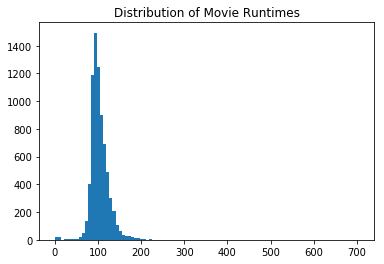

In [38]:
import statistics

ax = plt.hist(movies['runtime'], bins=100)
print("Max of runtime: {}".format(max(movies.runtime)))
print("Min of runtime: {}".format(min(movies.runtime)))
print("Mean of runtime: {:.4}".format(statistics.mean(movies.runtime)))

plt.title("Distribution of Movie Runtimes")


Max of popularity: 547.5
Min of popularity: 1e-06
Mean of popularity: 8.25


Text(0.5,1,'Distribution of Movie Popularity Rating')

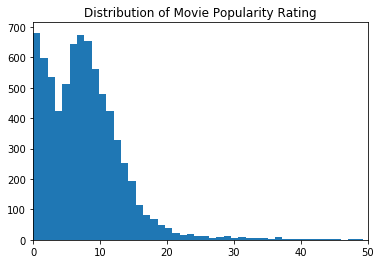

In [39]:
ax = plt.hist(movies['popularity'], bins=500)
print("Max of popularity: {:.4}".format(max(movies.popularity)))
print("Min of popularity: {:.3}".format(min(movies.popularity)))
print("Mean of popularity: {:.3}".format(statistics.mean(movies.popularity)))

plt.xlim(0,50)
plt.title("Distribution of Movie Popularity Rating")

Max of vote average: 10.0
Min of vote average: 0.0
Mean of vote average: 6.0


Text(0.5,1,'Distribution of Movie Average Vote Rating')

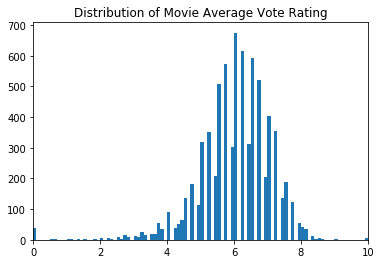

In [40]:
ax = plt.hist(movies['vote_average'], bins=100)
print("Max of vote average: {}".format(max(movies.vote_average)))
print("Min of vote average: {}".format(min(movies.vote_average)))
print("Mean of vote average: {:.2}".format(statistics.mean(movies.vote_average)))

plt.xlim(0,10)
plt.title("Distribution of Movie Average Vote Rating")

Max of vote count: 14075
Min of vote count: 0
Mean of vote count: 524.3


Text(0.5,1,'Distribution of Movie Average Vote Rating')

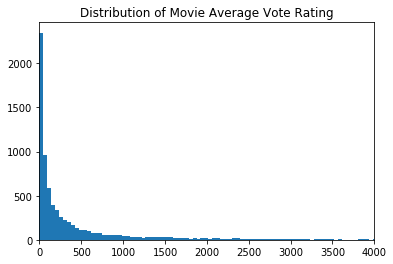

In [41]:
ax = plt.hist(movies['vote_count'], bins=300)
print("Max of vote count: {}".format(max(movies.vote_count)))
print("Min of vote count: {}".format(min(movies.vote_count)))
print("Mean of vote count: {:.4}".format(statistics.mean(movies.vote_count)))

plt.xlim(0,4000)
plt.title("Distribution of Movie Average Vote Rating")

### Example Genre Popularity (ROI) Plot

Examining time-series plot of the popularity of one specific genre (action) beginning in 1980:

C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 5000)

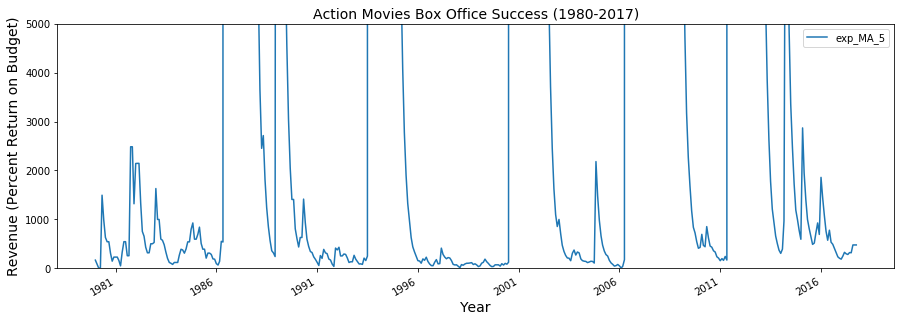

In [42]:
ts_action = ts_genre_pop[['mmyyyy','genre_action']]

ts_action['exp_MA_5'] = pd.Series.ewm(ts_action['genre_action'], span=5).mean()

ax = ts_action.plot(x='mmyyyy', y='exp_MA_5', figsize=(15,5))

ax.set_title("Action Movies Box Office Success (1980-2017)", fontsize=14)

ax.set_ylabel("Revenue (Percent Return on Budget)", fontsize=14)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylim(0,5000)

### ROI ratio for Large vs. Small Budget Films

We felt it was necessary to explore whether a particular average ROI ratio for a genre, for example 33%, would be equally applicable to both large budget films (in the hundreds of millions of dollars) as well as small budget films (under $1 million). To help answer this question, plotting ROI vs. Budget for all films in Movies dataset:

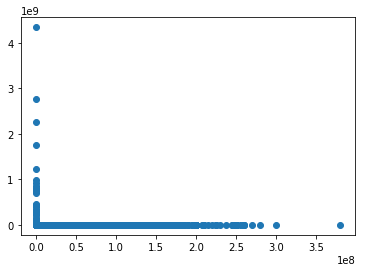

In [43]:
plt.scatter(movies.budget, movies.ROI_perc)

The above plot shows that there is clearly a correlation between ROI and budget - where lower budget films (1 million and under) are more likely to recoup their costs of production many times over (even in the tens of thousands of percent), while this is not common for higher budget films.

To get a better understanding of this variation, below we are summarizing the data in a slightly different way, i.e. breaking
the dataset into groups based on the range of budget (e.g. 1 million to 2 million, etc.) and looking at the average ROIs of 
individual groups.

In [44]:
budget_limits = [1e5, 1e6, 2e6, 5e6, 1e7, 2e7, 5e7, 1e8, 2e8, 3e8]
movies_summary = []
movies_layer_ROI = []

for i in range(0,len(budget_limits)-1):
    movies_summary.append(movies.loc[(movies.budget > budget_limits[i])&(movies.budget <= budget_limits[i+1])
                                    &(movies.Year.astype(int) >= 2007)])
    movies_layer_ROI.append(movies_summary[i]['ROI_perc'].groupby(movies['Year'], sort=False).mean())
    
movies_summary.append(movies.loc[(movies.budget > 100000)
                                    &(movies.Year.astype(int) >= 2007)])
movies_layer_ROI.append(movies_summary[9]['ROI_perc'].groupby(movies['Year'], sort=False).mean())

    
layer_ROI_compare = pd.DataFrame({'Year': np.asarray(movies_summary[0]['Year'])})

for i in range(0, len(movies_summary)):
    layer_ROI_compare = pd.merge(layer_ROI_compare, pd.DataFrame(movies_layer_ROI[i]), on='Year')

layer_ROI_compare = layer_ROI_compare.drop_duplicates()
    
layer_ROI_compare.columns = ['Year', '100k-1M', '1M-2M','2M-5M','5M-10M','10M-20M','20M-50M',
                             '50M-100M','100M-200M','200M-300M','Total Average']

layer_ROI_compare.round(1)

,Year,100k-1M,1M-2M,2M-5M,5M-10M,10M-20M,20M-50M,50M-100M,100M-200M,200M-300M,Total Average
0,2007,6007.3,1344.8,470.3,380.6,98.7,148.0,108.2,209.2,232.8,611.0
14,2008,5025.6,1774.3,431.0,152.9,148.8,121.2,149.7,197.2,86.5,571.1
32,2009,4322.1,2155.1,584.6,145.1,86.5,185.1,117.6,165.2,-366.3,513.1
49,2010,5592.2,1729.7,491.0,26.5,147.2,108.0,183.5,139.9,204.7,563.5
64,2012,5268.0,1069.0,540.1,113.7,105.7,151.1,225.0,218.8,244.9,864.0
96,2013,7243.5,1219.4,455.6,71.0,142.9,129.8,123.9,225.9,137.7,865.9
122,2014,5431.9,391.9,403.4,82.8,213.8,167.0,179.7,239.4,300.4,728.4
150,2015,4204.9,1041.9,678.3,149.9,62.7,168.6,233.1,257.7,468.5,572.8
168,2016,2736.8,992.9,501.7,207.6,122.1,122.0,288.8,182.8,305.3,342.5
178,2017,3369.8,2386.6,876.7,23.8,150.2,112.6,299.0,248.5,257.8,484.9


The above chart clearly shows the ROI differs significantly based on the budget range of the movie. For movies in the low
budget range (5 million and below) there is significant fluctuation in the ROI percentage year after year. 

Finally, below is a histogram we are using to examine what proportion of the movies fall into the "low budget" range. 
Clearly, a large percentage of the movies fall in this range:

Text(0,0.5,'Count')

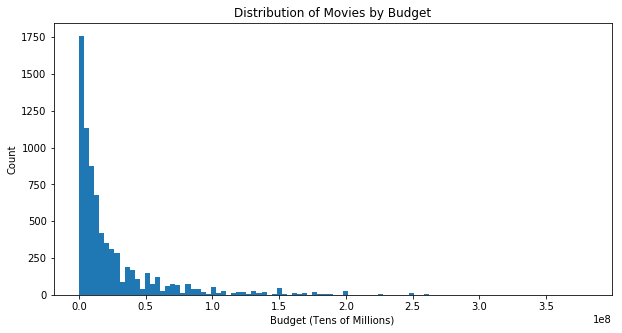

In [45]:
ax = movies['budget'].plot(kind='hist', bins=100, figsize=(10,5))
ax.set_title('Distribution of Movies by Budget')
ax.set_xlabel('Budget (Tens of Millions)')
ax.set_ylabel('Count')

### Adjusting for ROI Variation by Budget Layer

Clearly lower budget movies tend to have very volatile ROI percentages, while larger budget movies have a more stable average ROI percentage. One possible way to adjust for this effect in our model would be to calculate average ROI percentage for a particular genre in a given month/year using a weighted average. In other words:


<b>Monthly Weighted Average ROI</b> = ($\sum$ Genre X Movie Revenues in MMYYYY / $\sum$ Genre X Movie Budgets in MMYYYY) - 1

This way, each movie will impact the average ROI measure in proportion to its revenue/budget, i.e. many low-budget movies with exceptionally high returns (1000% or more) that happened to be closely clustered together in time will have a smaller impact on the ROI measure (and therefore the highest-ranking genre class) than if we used a straight average.


This requires first repeating the step from Part 1 where we group the movies dataset by month and year to return average ROI in a time period. Instead, we will modify that step to take weighted ROI average for a given time period:

In [46]:
# set movies dataset to modified 'movies_new' version

movies = movies_new.copy()

# create list of column names in movies dataset containing genre binary variables

dataset_genre_columns = list()

for i in range(0, len(unique_genres_list)):
        dataset_genre_columns.append("genre_" + unique_genres_list[i].lower().replace(" ","_"))
        
# create a list of column names in movies dataset corresponding to the average revenue and budget for each genre

genre_count = len(dataset_genre_columns)

for i in range(0, genre_count):
    dataset_genre_columns.append(dataset_genre_columns[i] + "_avg_revenue")    


for i in range(0, genre_count):
    dataset_genre_columns.append(dataset_genre_columns[i] + "_avg_budget")
        
#  create subset of movies dataset for each genre

subset_list = list()

for i in range(0, genre_count):
    subset_name = "movies_" + dataset_genre_columns[i]
    subset_list.append(movies.loc[movies[dataset_genre_columns[i]]==1])
    
#  create new time series dataset where the identifier is Month-Year (e.g. "Jun 2007")
#  merge all average genre popularity variables into one dataset

ts_genre_pop_wtd = pd.DataFrame({'Month': np.asarray(movies['MonthYear'])})

# add columns for genre ROI weighted averages one at a time

for i in range(0, len(subset_list)):
    series_revenue = subset_list[i]['revenue'].groupby(movies['MonthYear'], sort=False).sum()
    series_budget  = subset_list[i]['budget'].groupby(movies['MonthYear'], sort=False).sum()
    series_original = subset_list[i]['ROI_perc'].groupby(movies['MonthYear'], sort=False).mean()
    series_ROI = ((series_revenue.values / series_budget.values)-1)*100
    series_df = pd.DataFrame({'Month':series_revenue.index, 'ROI':series_ROI})
    ts_genre_pop_wtd = pd.merge(ts_genre_pop_wtd, series_df, on='Month', how='outer')
    ts_genre_pop_wtd = ts_genre_pop_wtd.drop_duplicates()
    
# add columns for genre average revenues one at a time

for i in range(0, len(subset_list)):
    series_revenue = subset_list[i]['revenue'].groupby(movies['MonthYear'], sort=False).mean()
    series_df = pd.DataFrame({'Month':series_revenue.index, 'revenue':series_revenue})
    ts_genre_pop_wtd = pd.merge(ts_genre_pop_wtd, series_df, on='Month', how='outer')
    ts_genre_pop_wtd = ts_genre_pop_wtd.drop_duplicates()
    
# add columns for genre average budgets one at a time

for i in range(0, len(subset_list)):
    series_budget = subset_list[i]['budget'].groupby(movies['MonthYear'], sort=False).mean()
    series_df = pd.DataFrame({'Month':series_budget.index, 'budget':series_budget})
    ts_genre_pop_wtd = pd.merge(ts_genre_pop_wtd, series_df, on='Month', how='outer')
    ts_genre_pop_wtd = ts_genre_pop_wtd.drop_duplicates()
                              
# set month as index variable and rename columns appropriately

ts_genre_pop_wtd.set_index('Month')

ts_genre_pop_wtd.columns.values[1:] = np.asarray(dataset_genre_columns)
    
# make copy of dataset with entire time range (1898-2017) and create subset with only Jan 1987 and onwards

# extract date as datetime object series from dataset

mmyyyy = []

from datetime import datetime

for i in range(0, len(ts_genre_pop_wtd)):
        mmyyyy.append(datetime.strptime(ts_genre_pop_wtd['Month'][i],'%b %Y'))

ts_genre_pop_wtd['mmyyyy'] = mmyyyy

ts_genre_pop_wtd = ts_genre_pop_wtd.loc[(ts_genre_pop_wtd['mmyyyy'] >= 'Jan 1980')]

ts_genre_pop_wtd.head()


C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,...,genre_thriller_avg_budget,genre_action_avg_budget,genre_romance_avg_budget,genre_crime_avg_budget,genre_adventure_avg_budget,genre_horror_avg_budget,genre_science_fiction_avg_budget,genre_family_avg_budget,genre_other_avg_budget,mmyyyy
459,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,...,11530337.80,6199455.00,NaN,11530337.8,NaN,NaN,6199455.00,7266428.0,7266428.00,1980-01-01
460,Feb 1980,106.678656,32.090384,209.164977,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,...,4389836.50,12063510.25,4800000.0,4800000.0,NaN,1000000.00,NaN,NaN,NaN,1980-02-01
461,Mar 1980,78.011546,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,...,20000000.00,20000000.00,8406267.0,NaN,20000000.0,250000.00,NaN,8406267.0,15000000.00,1980-03-01
462,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,...,14431475.25,NaN,NaN,NaN,NaN,14431475.25,14431475.25,NaN,14431475.25,1980-04-01
463,May 1980,104.364806,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,430.802941,2891.111111,...,19000000.00,18000000.00,NaN,NaN,18000000.0,9775000.00,18000000.00,NaN,7250000.00,1980-05-01


Next, we will follow the same steps as in part 1 to turn this into a time-series classification dataset (indicates which genre is the "most popular" in a given month):

In [47]:
# Strip columns with date format to apply max column (idxmax) function

ts_genre_class = ts_genre_pop_wtd.copy()

ts_genre_class = ts_genre_class[['genre_drama', 'genre_comedy','genre_thriller','genre_action',
                               'genre_romance','genre_crime','genre_adventure','genre_horror',
                               'genre_science_fiction', 'genre_family','genre_other']]

ts_genre_pop_wtd['Top Genre Wtd'] = ts_genre_class.idxmax(axis=1, skipna=True)

ts_genre_pop_wtd.head()

,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,...,genre_action_avg_budget,genre_romance_avg_budget,genre_crime_avg_budget,genre_adventure_avg_budget,genre_horror_avg_budget,genre_science_fiction_avg_budget,genre_family_avg_budget,genre_other_avg_budget,mmyyyy,Top Genre Wtd
459,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,...,6199455.00,NaN,11530337.8,NaN,NaN,6199455.00,7266428.0,7266428.00,1980-01-01,genre_action
460,Feb 1980,106.678656,32.090384,209.164977,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,...,12063510.25,4800000.0,4800000.0,NaN,1000000.00,NaN,NaN,NaN,1980-02-01,genre_horror
461,Mar 1980,78.011546,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,...,20000000.00,8406267.0,NaN,20000000.0,250000.00,NaN,8406267.0,15000000.00,1980-03-01,genre_horror
462,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,...,NaN,NaN,NaN,NaN,14431475.25,14431475.25,NaN,14431475.25,1980-04-01,genre_drama
463,May 1980,104.364806,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,430.802941,2891.111111,...,18000000.00,NaN,NaN,18000000.0,9775000.00,18000000.00,NaN,7250000.00,1980-05-01,genre_action


In [48]:
# remove 'genre_' from column name

ts_genre_pop = ts_genre_pop_wtd

Top_Genre_Wtd = []


for i in range(0, len(ts_genre_pop_wtd)):
    Top_Genre_Wtd.append(ts_genre_pop_wtd['Top Genre Wtd'].iloc[i][6:])
    
ts_genre_pop['Top Genre Wtd'] = Top_Genre_Wtd

Finally, we will add the "Weighted ROI" metric alongside the ROI metric in the ts_genre_pop table, which corresponds to a straight average monthly ROI percentage.

In [49]:
ts_genre_pop[['Month','genre_drama','genre_drama_avg_revenue','genre_drama_avg_budget','Top Genre Wtd']].head(10)

,Month,genre_drama,genre_drama_avg_revenue,genre_drama_avg_budget,Top Genre Wtd
459,Jan 1980,NaN,NaN,NaN,action
460,Feb 1980,106.678656,1.435947e+07,6.947728e+06,horror
461,Mar 1980,78.011546,2.575606e+07,1.446876e+07,horror
462,Apr 1980,1.228506,6.659377e+06,6.578559e+06,drama
463,May 1980,104.364806,1.420452e+07,6.950573e+06,action
464,Jun 1980,403.509730,3.712171e+07,7.372590e+06,drama
465,Jul 1980,492.034235,4.066803e+07,6.869202e+06,horror
466,Aug 1980,NaN,NaN,NaN,comedy
467,Sep 1980,-8.532184,9.651966e+06,1.055231e+07,horror
468,Oct 1980,160.226507,1.682783e+07,6.466607e+06,horror


# Part 3: Preparing and Adding Predictor Variables

### Election Year Binary Indicator

Import election year csv and store in data frame and explore the dataset.

In [50]:
election_year_raw = pd.read_csv('election years.csv')
election_year = election_year_raw

Inspect the data.

In [51]:
print(election_year.head())
print(election_year.dtypes)

   Year  Pres_Election  Midterm_Election
0  1980              1                 0
1  1981              0                 0
2  1982              0                 1
3  1983              0                 0
4  1984              1                 0
Year                int64
Pres_Election       int64
Midterm_Election    int64
dtype: object


We will create and use a period index since that will allow us to resample our data, which is currently listed by year, to be listed by month. By setting the convention parameter of resample to either 'start' or 'end' we can determine whether the yearly values are placed in January or December (the first or last place of the resampling). We choose January so that we can use ffill to fill the rest of a year with the same value as January since an entire year either is or is not an election year.

In [52]:
#Create a period index to allow use of convention parameter in resample
elyr_per_index = pd.period_range(start='1980', freq='y', periods=39)
election_year.index = elyr_per_index
election_year.index.name = 'MoYr_Index'

#resample the dataset using convention='start' to place the yearly values in Jan of each year
#ffill() propogates the rest of the months of each year from Jan values
election_year = election_year.resample('M', convention='start').asfreq().ffill()
election_year.head(25)

,Year,Pres_Election,Midterm_Election
MoYr_Index,,,
1980-01,1980.0,1.0,0.0
1980-02,1980.0,1.0,0.0
1980-03,1980.0,1.0,0.0
1980-04,1980.0,1.0,0.0
1980-05,1980.0,1.0,0.0
1980-06,1980.0,1.0,0.0
1980-07,1980.0,1.0,0.0
1980-08,1980.0,1.0,0.0
1980-09,1980.0,1.0,0.0


Filter out the now unnecessary year column and change the data types to be integers since the entries will be binary indicators.

In [53]:
election_year.index

PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', name='MoYr_Index', length=468, freq='M')

In [54]:
#remove year column
election_year = election_year.loc[:,['Pres_Election', 'Midterm_Election']]

#change dtypes
election_year['Pres_Election'] = election_year['Pres_Election'].astype(int)
election_year['Midterm_Election'] = election_year['Midterm_Election'].astype(int)

#reinspect data
print(election_year.dtypes)
print(election_year.index)
election_year.head()

Pres_Election       int32
Midterm_Election    int32
dtype: object
PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', name='MoYr_Index', length=468, freq='M')


,Pres_Election,Midterm_Election
MoYr_Index,,
1980-01,1,0
1980-02,1,0
1980-03,1,0
1980-04,1,0
1980-05,1,0


### Pre/Post 9/11 Binary Indicator

We will create a 9/11 reference variable. More specifically, we will create a simple binary indicator that will indicate whether a month and year came before or after September of 2001. 

In [55]:
#wtc for World Trade Center
wtc = pd.DataFrame()

We start by creating a period index to generate an index of the Months and Years from 1980-2018. We then use this period index to populate the first column of our dataframe. Lastly we create our indicator column, in which 1 indicates post-9/2001 and 0 indicates pre-9/2001 and set our default value to 1.

In [56]:
wtc_perindex = pd.period_range(start='01-01-1980', end='12-31-2018', freq='m')

#create a column with the index to place hold for the index
wtc['MonthYear'] = wtc_perindex
wtc['MonthYear'] = wtc['MonthYear'].dt.strftime('%b %Y')
wtc.index = wtc_perindex

wtc['Post_9/11_Attack'] = 1

In [57]:
#Examine wtc
wtc.head()

,MonthYear,Post_9/11_Attack
1980-01,Jan 1980,1
1980-02,Feb 1980,1
1980-03,Mar 1980,1
1980-04,Apr 1980,1
1980-05,May 1980,1


Next we will take a slice from wtc that includes all of the Month-Years from 1980-01 until 2001-08. This slice comprises the entire period of time before the attack and thus is the subset of wtc which should have an indicator of 0. We set the value of the indicator column to 0 for this slice and then merge the slice back into the wtc dataframe. This yields a dataframe with a binary indicator of which months and years precede or come after the 9/11 attacks.

In [58]:
#set value of all rows indexed by date < 9/2001 to 0
pre_attack = wtc.loc['1980-01':'2001-08',:]
pre_attack['Post_9/11_Attack'] = 0
pre_attack

C:\Users\sarva\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,MonthYear,Post_9/11_Attack
1980-01,Jan 1980,0
1980-02,Feb 1980,0
1980-03,Mar 1980,0
1980-04,Apr 1980,0
1980-05,May 1980,0
1980-06,Jun 1980,0
1980-07,Jul 1980,0
1980-08,Aug 1980,0
1980-09,Sep 1980,0
1980-10,Oct 1980,0


In [59]:
#merge pre_attack with wtc create binary indicator column
wtc = wtc.merge(pre_attack, how='outer')

#reindex by the original period index (lost during merge)
wtc.index = wtc_perindex

print(wtc.head())
#Use below for visual confirmation 
#confirm indicator switch is at 9/2001
#confirm that indicator is correct at beginning and end
#print(wtc.head(270))
#print(wtc)

        MonthYear  Post_9/11_Attack
1980-01  Jan 1980                 0
1980-02  Feb 1980                 0
1980-03  Mar 1980                 0
1980-04  Apr 1980                 0
1980-05  May 1980                 0


### Presidential Approval Ratings

First, we import the data from the csv and load into a pandas dataframe.

In [60]:
pres_approval_raw = pd.read_csv('pres_approval.csv')
pres_approval = pres_approval_raw

Then we inspect the dataframe structure, datatypes, and investigate data for any missing or Na values.

In [61]:
print(pres_approval.head())
print(pres_approval.index)
print(pres_approval.dtypes)

   Start_Date    End_Date  Approving  Disapproving  Unsure_NoData
0  10/08/2018  10/14/2018         44            51              5
1  10/01/2018  10/07/2018         43            53              4
2  09/24/2018  09/30/2018         42            53              5
3  09/17/2018  09/23/2018         40            56              4
4  09/10/2018  09/16/2018         38            56              6
RangeIndex(start=0, stop=3698, step=1)
Start_Date       object
End_Date         object
Approving         int64
Disapproving      int64
Unsure_NoData     int64
dtype: object


In [62]:
#use strip method to remove spaces from the column names
pres_approval.columns = pres_approval.columns.str.strip()
pres_approval.columns

Index(['Start_Date', 'End_Date', 'Approving', 'Disapproving', 'Unsure_NoData'], dtype='object')

Check for missing or Na data by creating a "check" dataframe that filters out any rows with missing or Na data. Then compare the number of rows in pres_approval_check to pres_approval. Because we are moving towards the creating of a time series it is important to know if there are any missing or Na entries before removing rows because removing rows could create more information loss when grouping by month.

In [63]:
for column in pres_approval:
    pres_approval_check = pres_approval.loc[(pres_approval[column].isna()==False) & (pres_approval[column].isnull()==False)]

In [64]:
print(pres_approval_check.index)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697],
           dtype='int64', length=3698)


There are no missing or NaN values, hurray!

Next, we change date columns to appropriate datetime data type.

In [65]:
pres_approval['Start_Date'] = pd.to_datetime(pres_approval['Start_Date'])
pres_approval['End_Date'] = pd.to_datetime(pres_approval['End_Date'])

pres_approval.dtypes

Start_Date       datetime64[ns]
End_Date         datetime64[ns]
Approving                 int64
Disapproving              int64
Unsure_NoData             int64
dtype: object

We use the 'End_Date' column to create a new column called 'MonthYear' which stores the month and year from the end of the polling period for later referrence. This will be helpful both for creating period indecies later and for referrence to the main movies time series. Since we are eventually looking to find the average approval rating for a month we choose to index on End_Date.

In [66]:
pres_approval['MonthYear'] = pres_approval['End_Date'].dt.strftime('%b %Y')

#convert MonthYear dtype to datetime
pres_approval['MonthYear'] = pd.to_datetime(pres_approval['MonthYear'])

print(pres_approval.head())
pres_approval.dtypes

  Start_Date   End_Date  Approving  Disapproving  Unsure_NoData  MonthYear
0 2018-10-08 2018-10-14         44            51              5 2018-10-01
1 2018-10-01 2018-10-07         43            53              4 2018-10-01
2 2018-09-24 2018-09-30         42            53              5 2018-09-01
3 2018-09-17 2018-09-23         40            56              4 2018-09-01
4 2018-09-10 2018-09-16         38            56              6 2018-09-01


Start_Date       datetime64[ns]
End_Date         datetime64[ns]
Approving                 int64
Disapproving              int64
Unsure_NoData             int64
MonthYear        datetime64[ns]
dtype: object

Change pres_approval index to a datetime index for purposes of grouping by month using the resample() method. We must use resmaple instead of groupby because resample will fill any month-year periods where there is no data with Nan values whereas groupby will remove those month-year periods. Since we will eventually be merging this data with another time series, it is crucial that we not lose any periods of time due to lack of data. We will later fill in any Nan's with average values.

In [67]:
pres_index = pres_approval['MonthYear']
pres_approval.index = pres_index
pres_approval.index.name = 'MoYR_Index'
pres_approval.index = pd.to_datetime(pres_approval.index)

Reinspect the data

In [68]:
print(pres_approval.head())
print(pres_approval.dtypes)
print(pres_approval.index)

           Start_Date   End_Date  Approving  Disapproving  Unsure_NoData  \
MoYR_Index                                                                 
2018-10-01 2018-10-08 2018-10-14         44            51              5   
2018-10-01 2018-10-01 2018-10-07         43            53              4   
2018-09-01 2018-09-24 2018-09-30         42            53              5   
2018-09-01 2018-09-17 2018-09-23         40            56              4   
2018-09-01 2018-09-10 2018-09-16         38            56              6   

            MonthYear  
MoYR_Index             
2018-10-01 2018-10-01  
2018-10-01 2018-10-01  
2018-09-01 2018-09-01  
2018-09-01 2018-09-01  
2018-09-01 2018-09-01  
Start_Date       datetime64[ns]
End_Date         datetime64[ns]
Approving                 int64
Disapproving              int64
Unsure_NoData             int64
MonthYear        datetime64[ns]
dtype: object
DatetimeIndex(['2018-10-01', '2018-10-01', '2018-09-01', '2018-09-01',
               '2018-0

Using resample, we call the mean() function on the resample() method to group data by month, calculate the mean of monthly data, and output a time series indicating average monthly values. Again, note that resample preserves months with no data and fills them with Nan values. Since the resample method outputs a reampler object, we must store the resampled data in holding variable and then create a new data frame ts_pres_approval into which we import the resampled data from the holder. Then we will have a dataframe which we can work with containing the resampled data.

In [69]:
#resample data and store in a holding variable
ts_pres_approval_holder = pres_approval.resample('M').mean()

#create new dataframe and import resampled data from the holder
ts_pres_approval = pd.DataFrame()
ts_pres_approval = ts_pres_approval_holder
ts_pres_approval.head()

,Approving,Disapproving,Unsure_NoData
MoYR_Index,,,
1980-01-31,56.0,33.333333,9.0
1980-02-29,51.0,38.000000,10.0
1980-03-31,40.5,47.000000,11.0
1980-04-30,40.0,48.500000,10.0
1980-05-31,38.0,50.500000,10.0


Now that we have resampled the data, the next step is reindex the time series to a period index which will be used going forward (datetimeindex is required for the resample method).

In [70]:
#create index series for global use

#Monthly period index Jan 1980 - Oct 2018
Mperiod_index = pd.period_range(start='1980, 01, 01', freq='M', periods=466)

#Yearly period index 1980 - 2018
Yperiod_index = pd.period_range(start='1980', freq='y', periods=39)

In [71]:
#reindex time series as a period index
ts_pres_approval.index = Mperiod_index
ts_pres_approval.head(20)

,Approving,Disapproving,Unsure_NoData
1980-01,56.000000,33.333333,9.0
1980-02,51.000000,38.000000,10.0
1980-03,40.500000,47.000000,11.0
1980-04,40.000000,48.500000,10.0
1980-05,38.000000,50.500000,10.0
1980-06,31.000000,56.500000,10.5
1980-07,32.000000,54.000000,12.0
1980-08,32.000000,54.000000,13.0
1980-09,37.000000,54.000000,7.0
1980-10,NaN,NaN,NaN


After inspecting the time series, we can see just from looking that there are some months for which we have no data. There are two simple options for dealing with this. One would be two filter out the data, however, since we are planning on grafting this time series onto our larger dataset it would not make sense to drop rows. The better option would seem to be to replace NaN values with an average value.

For our purposes we will replace missing values with the average value for the same year from which the value is missing. This would most accurately replace missing data since it would be an average of values for the same sitting president with a similar state of affairs in the world in almost all conceivable cases.

option 1: filter out rows

In [72]:
#for column in pres_approval:
#    pres_approval = pres_approval.loc[(pres_approval[column].isna()==False) & (pres_approval[column].isnull()==False)]

option 2: We replace with yearly averages using resample to find yearly averages.

First we use resampling to generate a dataframe indexed by month from Jan 1980 to Oct 2018 which stores the yearly average for each value in each month of a given year.

In [73]:
#resample the pres_approval data to find yearly averages
yr_avg = pres_approval.resample('Y').mean()
yr_avg.index = Yperiod_index

#resample again back to a montly period index
#use convention start to place yearly avg in January
#use ffill to propogate the rest of the months
yr_avg = yr_avg.resample('M', convention='start').asfreq().ffill()

#remove Nov and Dec 201 which were added in the resampling process but are not included in the main time series
yr_avg = yr_avg.iloc[0:466,:]
yr_avg.tail()

,Approving,Disapproving,Unsure_NoData
2018-06,40.390244,54.780488,4.829268
2018-07,40.390244,54.780488,4.829268
2018-08,40.390244,54.780488,4.829268
2018-09,40.390244,54.780488,4.829268
2018-10,40.390244,54.780488,4.829268


Next, we generate series from the columns of yr_avg to be called by the fillna() function. Then use the fillna function on each column of ts_pres_approval to fill fill in the Nan values of each column with the yearly averages from yr_avg.

In [74]:
#Create series
yravg_app_ser = yr_avg['Approving']
yravg_disapp_ser = yr_avg['Disapproving']
yravg_nodata_ser = yr_avg['Unsure_NoData']

#Substitute yearly avg for Nan values
ts_pres_approval['Approving'] = ts_pres_approval['Approving'].fillna(yravg_app_ser)
ts_pres_approval['Disapproving'] = ts_pres_approval['Disapproving'].fillna(yravg_disapp_ser)
ts_pres_approval['Unsure_NoData'] = ts_pres_approval['Unsure_NoData'].fillna(yravg_nodata_ser)

We inspect our dataframe again to see the substitutions.

In [75]:
ts_pres_approval.head(25)

,Approving,Disapproving,Unsure_NoData
1980-01,56.000000,33.333333,9.000000
1980-02,51.000000,38.000000,10.000000
1980-03,40.500000,47.000000,11.000000
1980-04,40.000000,48.500000,10.000000
1980-05,38.000000,50.500000,10.000000
1980-06,31.000000,56.500000,10.500000
1980-07,32.000000,54.000000,12.000000
1980-08,32.000000,54.000000,13.000000
1980-09,37.000000,54.000000,7.000000
1980-10,40.235294,48.000000,10.294118


Optional: add MonthYear as a column to ts_pres_approval for referrence.

We do this by creating a new dataframe and merging it with ts_pres_aproval. The new data frame created will contain a single column with month and year data generated from the period index of the ts_pres_approval.

In [76]:
#create MonthYear dataframe
MonthYear_series = ts_pres_approval.index.to_series(name='MonthYear')
MonthYear_df = MonthYear_series.to_frame(name='MonthYear')
MonthYear_df['MonthYear'] = MonthYear_df['MonthYear'].dt.strftime('%b %Y')
MonthYear_df.index = Mperiod_index
MonthYear_df.head()

,MonthYear
1980-01,Jan 1980
1980-02,Feb 1980
1980-03,Mar 1980
1980-04,Apr 1980
1980-05,May 1980


In [77]:
#add the MonthYear column to the time series using merge
ts_pres_approval = ts_pres_approval.merge(MonthYear_df, how = 'left', left_index = True, right_index = True)
ts_pres_approval.head(20)

,Approving,Disapproving,Unsure_NoData,MonthYear
1980-01,56.000000,33.333333,9.000000,Jan 1980
1980-02,51.000000,38.000000,10.000000,Feb 1980
1980-03,40.500000,47.000000,11.000000,Mar 1980
1980-04,40.000000,48.500000,10.000000,Apr 1980
1980-05,38.000000,50.500000,10.000000,May 1980
1980-06,31.000000,56.500000,10.500000,Jun 1980
1980-07,32.000000,54.000000,12.000000,Jul 1980
1980-08,32.000000,54.000000,13.000000,Aug 1980
1980-09,37.000000,54.000000,7.000000,Sep 1980
1980-10,40.235294,48.000000,10.294118,Oct 1980


We now have a time series of average monthly presidential approval ratings from Jan 1980 - Oct 2018, and binary indicators of whether or not a given month and year is in an election year, or before or after 9/11 over the same time series, that can be merged with our main dataframe.

In [78]:
#time series containing avg monthly pres approval ratings
ts_pres_approval.head()

,Approving,Disapproving,Unsure_NoData,MonthYear
1980-01,56.0,33.333333,9.0,Jan 1980
1980-02,51.0,38.000000,10.0,Feb 1980
1980-03,40.5,47.000000,11.0,Mar 1980
1980-04,40.0,48.500000,10.0,Apr 1980
1980-05,38.0,50.500000,10.0,May 1980


In [79]:
#binary indicator for before/after 9/11 over pres approval time series
#0 = before
#1 = after
wtc = wtc[['Post_9/11_Attack']]
wtc.head()

,Post_9/11_Attack
1980-01,0
1980-02,0
1980-03,0
1980-04,0
1980-05,0


In [80]:
#binary indicator for election years over pres approval time series
election_year.head()

,Pres_Election,Midterm_Election
MoYr_Index,,
1980-01,1,0
1980-02,1,0
1980-03,1,0
1980-04,1,0
1980-05,1,0


In [81]:
#merge socio-political dataframes into one time series
ts_soc_pol = ts_pres_approval.merge(election_year, how = 'left', left_index = True, right_index = True)
ts_soc_pol = ts_soc_pol.merge(wtc, how = 'left', left_index = True, right_index = True)

#trim off last year from times series to match time series of ts_genre_pop
ts_soc_pol = ts_soc_pol.iloc[0:454,:]
ts_soc_pol.head()

,Approving,Disapproving,Unsure_NoData,MonthYear,Pres_Election,Midterm_Election,Post_9/11_Attack
1980-01,56.0,33.333333,9.0,Jan 1980,1,0,0
1980-02,51.0,38.000000,10.0,Feb 1980,1,0,0
1980-03,40.5,47.000000,11.0,Mar 1980,1,0,0
1980-04,40.0,48.500000,10.0,Apr 1980,1,0,0
1980-05,38.0,50.500000,10.0,May 1980,1,0,0


In [82]:
ts_genre_pop = ts_genre_pop.merge(ts_soc_pol, how='left', left_on='Month', right_on='MonthYear')
ts_genre_pop.head()

,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,...,genre_other_avg_budget,mmyyyy,Top Genre Wtd,Approving,Disapproving,Unsure_NoData,MonthYear,Pres_Election,Midterm_Election,Post_9/11_Attack
0,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,...,7266428.00,1980-01-01,action,56.0,33.333333,9.0,Jan 1980,1,0,0
1,Feb 1980,106.678656,32.090384,209.164977,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,...,NaN,1980-02-01,horror,51.0,38.000000,10.0,Feb 1980,1,0,0
2,Mar 1980,78.011546,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,...,15000000.00,1980-03-01,horror,40.5,47.000000,11.0,Mar 1980,1,0,0
3,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,...,14431475.25,1980-04-01,drama,40.0,48.500000,10.0,Apr 1980,1,0,0
4,May 1980,104.364806,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,430.802941,2891.111111,...,7250000.00,1980-05-01,action,38.0,50.500000,10.0,May 1980,1,0,0


### Economic Indicators: Consumer Confidence, Real GDP Growth, Unemployment Rate

Import datasets from FRED (Federal Reserve Bank of St. Louis) website containing monthly and quarterly data on consumer sentiment, real GDP change, and unemployment rate.

In [83]:
# import consumer confidence dataset 

cconf = pd.read_excel('consumer_conf.xlsx', skiprows=10)

cconf = cconf.set_index('observation_date')

cconf.tail()

,UMCSENT
observation_date,
2018-04-01,98.8
2018-05-01,98.0
2018-06-01,98.2
2018-07-01,97.9
2018-08-01,96.2


In [84]:
# import unemployment rate dataset

unemp = pd.read_excel('unemp.xlsx', skiprows=10)

unemp = unemp.set_index('observation_date')

unemp.tail()

,UNRATE
observation_date,
2018-06-01,4.0
2018-07-01,3.9
2018-08-01,3.9
2018-09-01,3.7
2018-10-01,3.7


In [85]:
# import real GDP change dataset

rgdp = pd.read_excel('realgdp.xlsx', skiprows=10)

rgdp.tail()

,observation_date,A191RL1Q225SBEA
278,2017-07-01,2.8
279,2017-10-01,2.3
280,2018-01-01,2.2
281,2018-04-01,4.2
282,2018-07-01,3.5


### Formatting economic indicator time series

Some preprocessing is required before we can use the "Real GDP Change" variable in our dataset. The data is quarterly, it must be transformed into a monthly time series. We will do this in four different ways:<br><br>
1) <b>V1</b>: "Forward" view: A given value on Jan 2000, for example, is extended to Feb 2000 and Mar 2000 as well. <br>
2) <b>V2</b>: "Backward" view: A given value on Jan 2000, for example, is extended to Dec 1999 and Nov 1999 as well. <br>
3) <b>V3</b>: "Midpoint" view: A given value on Jan 2000, for example, is extended to Dec 1999 and Feb 2000 as well. <br>
4) <b>V4</b>: Linear interpolation between quarterly datapoints to obtain each month's value for Real GDP Change. <br>

In the following steps, the Real GDP dataset is being modified as described above and the four versions of the variable are being appended to the main dataset. Also, consumer confidence and unemployment rate variable columns are appended to the main dataset.

In [86]:
rgdp.columns.values[1] = 'RGDP_Chg'

# Use resample method to extend quarterly datasets to monthly

rgdp1 = rgdp.set_index('observation_date').resample('MS').bfill().reset_index()
rgdp2 = rgdp.set_index('observation_date').resample('MS').ffill(2).reset_index()
rgdp3 = pd.DataFrame(rgdp2['observation_date'])
rgdp3.set_index('observation_date')
rgdp4 = rgdp.set_index('observation_date').resample('MS').interpolate().reset_index()

In [87]:
# In case of midpoint time series (V3), shift by 1 

rgdp3['RGDP_Chg'] = rgdp1['RGDP_Chg'].shift(1)

In [88]:
# Filter all variables to be from 1980 to 2017 (Oct) to match primary dataset

rgdp1 = rgdp1.set_index('observation_date')
rgdp1 = rgdp1.loc[rgdp1.index>='1980-01-01']
#rgdp1 = rgdp1.loc[rgdp1.index<='2017-10-01']

rgdp2 = rgdp2.set_index('observation_date')
rgdp2 = rgdp2.loc[rgdp2.index>='1980-01-01']
#rgdp2 = rgdp2.loc[rgdp2.index<='2017-10-01']

rgdp3 = rgdp3.set_index('observation_date')
rgdp3 = rgdp3.loc[rgdp3.index>='1980-01-01']
#rgdp3 = rgdp3.loc[rgdp3.index<='2017-10-01']

rgdp4 = rgdp4.set_index('observation_date')
rgdp4 = rgdp4.loc[rgdp4.index>='1980-01-01']
#rgdp4 = rgdp4.loc[rgdp4.index<='2017-10-01']


In [89]:
# Add in variables for consumer confidence and unemployment rate

cconf = cconf.loc[cconf.index>='1980-01-01']
cconf = cconf.loc[cconf.index<='2017-10-01']

unemp = unemp.loc[unemp.index>='1980-01-01']
unemp = unemp.loc[unemp.index<='2017-10-01']

rgdp1['mmyyyy'] = rgdp1.index
rgdp2['mmyyyy'] = rgdp2.index
rgdp3['mmyyyy'] = rgdp3.index
rgdp4['mmyyyy'] = rgdp4.index
cconf['mmyyyy'] = cconf.index
unemp['mmyyyy'] = unemp.index



In [90]:
# Merge all variables on main dataset and rename

ts_genre_pop = ts_genre_pop.merge(rgdp1, how='right', on='mmyyyy')
ts_genre_pop = ts_genre_pop.rename(columns={'RGDP_Chg': 'RGDP_Chg_V1'})
ts_genre_pop = ts_genre_pop.merge(rgdp2, how='right', on='mmyyyy')
ts_genre_pop = ts_genre_pop.rename(columns={'RGDP_Chg': 'RGDP_Chg_V2'})
ts_genre_pop = ts_genre_pop.merge(rgdp3, how='right', on='mmyyyy')
ts_genre_pop = ts_genre_pop.rename(columns={'RGDP_Chg': 'RGDP_Chg_V3'})
ts_genre_pop = ts_genre_pop.merge(rgdp4, how='right', on='mmyyyy')
ts_genre_pop = ts_genre_pop.rename(columns={'RGDP_Chg': 'RGDP_Chg_V4'})
ts_genre_pop = ts_genre_pop.merge(cconf, how='right', on='mmyyyy')
ts_genre_pop = ts_genre_pop.rename(columns={'UMCSENT': 'cconf'})
ts_genre_pop = ts_genre_pop.merge(unemp, how='right', on='mmyyyy')
ts_genre_pop = ts_genre_pop.rename(columns={'UNRATE': 'unemp'})

In [91]:
ts_genre_pop.tail(5)

,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,...,MonthYear,Pres_Election,Midterm_Election,Post_9/11_Attack,RGDP_Chg_V1,RGDP_Chg_V2,RGDP_Chg_V3,RGDP_Chg_V4,cconf,unemp
449,Jun 2017,12.521617,335.201806,157.654074,334.376881,61.736190,419.842852,272.3365,929.386926,153.460502,...,Jun 2017,0.0,0.0,1.0,2.8,3.0,2.8,2.866667,95.0,4.3
450,Jul 2017,233.407241,33.827878,301.459660,369.142226,15484.255000,42.673377,NaN,NaN,143.360502,...,Jul 2017,0.0,0.0,1.0,2.8,2.8,2.8,2.800000,93.4,4.3
451,Aug 2017,13.210332,NaN,554.054259,260.239725,NaN,1579.729136,NaN,18.333333,18.333333,...,Aug 2017,0.0,0.0,1.0,2.3,2.8,2.8,2.633333,96.8,4.4
452,Oct 2017,478.995425,NaN,NaN,NaN,478.995425,NaN,NaN,NaN,NaN,...,Oct 2017,0.0,0.0,1.0,2.3,2.3,2.3,2.300000,100.7,4.1
453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.3,2.8,2.3,2.466667,95.1,4.2


The last 3 rows of the ts_genre_pop dataset have a lot of N/As. Actually, the last row doesn't correspond to any month at all (possibly due to an issue during the merge). Will eliminate these last three rows.

In [92]:
ts_genre_pop = ts_genre_pop.loc[ts_genre_pop['mmyyyy']<='2017-07-01']

### Adding "Three-Category" Target Variable

In [93]:
ts_genre_pop['Top Genre Wtd'].value_counts()

horror             114
romance             58
family              45
science_fiction     36
adventure           34
comedy              32
crime               31
drama               29
action              26
thriller            24
other               22
Name: Top Genre Wtd, dtype: int64

In [94]:
GenreSimple = []

for genre in ts_genre_pop['Top Genre Wtd']:
    if genre == 'horror':
        GenreSimple.append("horror")
    elif genre == 'romance' or genre == 'family' or genre == 'comedy':
        GenreSimple.append("RFC")
    else:
        GenreSimple.append("other")

ts_genre_pop['GenreSimple'] = GenreSimple
        

In [95]:
ts_genre_pop.head()

,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,...,Pres_Election,Midterm_Election,Post_9/11_Attack,RGDP_Chg_V1,RGDP_Chg_V2,RGDP_Chg_V3,RGDP_Chg_V4,cconf,unemp,GenreSimple
0,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,...,1.0,0.0,0.0,1.3,1.3,1.3,1.3,67.0,6.3,other
1,Feb 1980,106.678656,32.090384,209.164977,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,...,1.0,0.0,0.0,-8.0,1.3,1.3,-1.8,66.9,6.3,horror
2,Mar 1980,78.011546,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,...,1.0,0.0,0.0,-8.0,1.3,-8.0,-4.9,56.5,6.3,horror
3,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,...,1.0,0.0,0.0,-8.0,-8.0,-8.0,-8.0,52.7,6.9,other
4,May 1980,104.364806,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,430.802941,2891.111111,...,1.0,0.0,0.0,-0.5,-8.0,-8.0,-5.5,51.7,7.5,other


### Adding "Month" Predictor Variable

Adding an input variable that specifies the month of the year for a given data point (Jan - Dec) may help with predicting seasonality effects in the model. Since "Jan", "Feb", "Mar", etc. are dummy categorical variables, we will implement this instead with 12 binary variables, one for each month.

In [96]:
# Create an empty list and then create list of lists containers
# One for each month

month_var = []
month_index = list(np.linspace(1, 12, 12).astype(int))

for i in range(1, 13):
    month_var.append([])

# Loop through each row of dataset
# Add 1 to applicable month in month_var and 0 to rest

mth = [x.month for x in ts_genre_pop['mmyyyy']]

for i in mth:
    for j in range(1,13):
        if j==i:
            month_var[j-1].append(1)
        else:
            month_var[j-1].append(0)  
            
ts_genre_pop['month_jan'] = month_var[0]
ts_genre_pop['month_feb'] = month_var[1]
ts_genre_pop['month_mar'] = month_var[2]
ts_genre_pop['month_apr'] = month_var[3]
ts_genre_pop['month_may'] = month_var[4]
ts_genre_pop['month_jun'] = month_var[5]
ts_genre_pop['month_jul'] = month_var[6]
ts_genre_pop['month_aug'] = month_var[7]
ts_genre_pop['month_sep'] = month_var[8]
ts_genre_pop['month_oct'] = month_var[9]
ts_genre_pop['month_nov'] = month_var[10]
ts_genre_pop['month_dec'] = month_var[11]

In [97]:
ts_genre_pop.head()

,Month,genre_drama,genre_comedy,genre_thriller,genre_action,genre_romance,genre_crime,genre_adventure,genre_horror,genre_science_fiction,...,month_mar,month_apr,month_may,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec
0,Jan 1980,NaN,-72.294599,-22.861852,168.536508,NaN,-22.861852,NaN,NaN,168.536508,...,0,0,0,0,0,0,0,0,0,0
1,Feb 1980,106.678656,32.090384,209.164977,32.090384,373.826542,373.826542,NaN,2037.836100,NaN,...,0,0,0,0,0,0,0,0,0,0
2,Mar 1980,78.011546,-24.801437,-81.180060,-81.180060,-24.801437,NaN,-81.180060,8998.924000,NaN,...,1,0,0,0,0,0,0,0,0,0
3,Apr 1980,1.228506,1.228506,-65.353507,NaN,NaN,NaN,NaN,-65.353507,-65.353507,...,0,1,0,0,0,0,0,0,0,0
4,May 1980,104.364806,300.000000,131.670389,2891.111111,NaN,NaN,2891.111111,430.802941,2891.111111,...,0,0,1,0,0,0,0,0,0,0


We are now ready to use our dataset to train and test various models. Exported for easier future reference.

In [98]:
ts_genre_pop.to_csv('ts_genre_pop.csv')

# Part 4: Model Testing and Selection

The first step is to create a "genre" dictionary that consists of the input variables and target values from the primary dataset (ts_genre_pop) listed separately.

In [99]:
data_values = ts_genre_pop[['Pres_Election', 'Midterm_Election','Post_9/11_Attack','RGDP_Chg_V1',
                            'RGDP_Chg_V2','RGDP_Chg_V3','RGDP_Chg_V4','cconf','unemp', 'Approving',
                            'Disapproving', 'Unsure_NoData','month_jan',
                           'month_feb','month_mar','month_apr','month_may','month_jun','month_jul',
                           'month_aug','month_sep','month_oct','month_nov','month_dec']].values

data_values_mo = ts_genre_pop[['month_jan','month_feb','month_mar','month_apr','month_may','month_jun','month_jul',
                           'month_aug','month_sep','month_oct','month_nov','month_dec']].values

data_values_nomo = ts_genre_pop[['Pres_Election', 'Midterm_Election','Post_9/11_Attack','RGDP_Chg_V1',
                            'RGDP_Chg_V2','RGDP_Chg_V3','RGDP_Chg_V4', 'Approving','Disapproving','Unsure_NoData',
                                 'cconf','unemp']].values

target_values = ts_genre_pop['Top Genre Wtd'].values

target_simple_values = ts_genre_pop['GenreSimple'].values

feature_names = ['Pres_Election', 'Midterm_Election','Post_9/11_Attack','RGDP_Chg_V1',
                            'RGDP_Chg_V2','RGDP_Chg_V3','RGDP_Chg_V4','cconf','unemp','Approving','Disapproving',
                 'Unsure_NoData','month_jan'
                           'month_feb','month_mar','month_apr','month_may','month_jun','month_jul',
                           'month_aug','month_sep','month_oct','month_nov','month_dec']


In [100]:
data_values_scaled=(data_values-data_values.mean())/data_values.std()
data_values_nomo_scl = (data_values_nomo-data_values_nomo.mean())/data_values_nomo.std()

In [101]:
genre = {'data':data_values_scaled, 'data_nomo':data_values_nomo_scl, 'data_mo':data_values_mo, 'target':target_values, 'target_simple': target_simple_values}

Next, we will use the train_test_split method to randomly split the genre dataset into a training and test dataset for the model.

In [102]:
from sklearn.model_selection import train_test_split
from numpy import shape

X_train, X_test, y_train, y_test = train_test_split(genre['data'], genre['target'], random_state=42)
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(genre['data'], genre['target_simple'], random_state=42)

#more train/test sets seperating the month/year predictor values from all other predictor variables
X_train_mo, X_test_mo, y_train_mo, y_test_mo = train_test_split(genre['data_mo'], genre['target'], random_state=42)
X_train_nomo, X_test_nomo, y_train_nomo, y_test_nomo = train_test_split(genre['data_nomo'], genre['target'], random_state=42)
X_train_msim, X_test_msim, y_train_msim, y_test_msim = train_test_split(genre['data_mo'], genre['target_simple'], random_state=42)
X_train_nmsim, X_test_nmsim, y_train_nmsim, y_test_nmsim = train_test_split(genre['data_nomo'], genre['target_simple'], random_state=42)

print("The shape of the training dataset is:{}".format(shape(X_train)))
print("The shape of the test dataset is:{}".format(shape(X_test)))

The shape of the training dataset is:(338, 24)
The shape of the test dataset is:(113, 24)


### Model 1: Linear SGD Classifier

We will start with a linear SGD (stochastic gradient descent) classifier. Below, using RFE (recursive feature elimination) to determine the N features with the most predictive power in the model (out of 21) using step-wise regression.

In [103]:
# 10-genre classifier 

from sklearn import linear_model
from sklearn.feature_selection import RFE

min_features = 5
max_features = 21

clf = linear_model.SGDClassifier(max_iter=1000, random_state=42)

test_acc = []

for i in range(min_features, max_features+1):  
    selector = RFE(clf, i, step=1)
    selector = selector.fit(X_train, y_train)
    test_acc.append(selector.score(X_test, y_test))
    
# choose model with max accuracy on test set as 'selector' model

selector = RFE(clf, test_acc.index(max(test_acc))+min_features, step=1)

selector = selector.fit(X_train, y_train)

Number of features in model with maximum test accuracy: 12
Accuracy on training set: 0.178
Accuracy on test set: 0.186
['family' 'crime' 'family' 'thriller' 'family' 'crime' 'thriller' 'crime'
 'thriller' 'thriller' 'thriller' 'family' 'crime' 'thriller' 'family'
 'crime' 'thriller' 'horror' 'family' 'family']


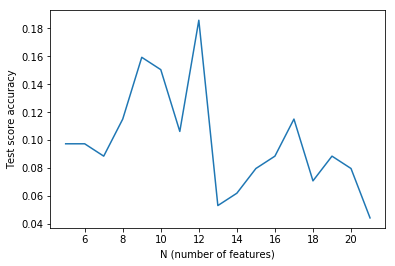

In [104]:
# Plot test accuracy for each model with N features selected from RFE method

plt.plot(range(min_features, max_features+1), test_acc)
plt.xlabel('N (number of features)')
plt.ylabel('Test score accuracy')

print("Number of features in model with maximum test accuracy: {}".format(min_features+ test_acc.index(max(test_acc))))

print("Accuracy on training set: {:.3f}".format(selector.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(selector.score(X_test, y_test)))

print(selector.predict(X_test)[0:20])

<b>Testing the performance of a Linear SGD Classifier on the "Simple Genre" categorization datasest </b>

Below, the same process is repeated on the "Simple Genre" dataset, which only has 3 possible target values (Horror, RFC, Other) instead of 10.

In [105]:
# Simple-genre classifier 

from sklearn import linear_model
from sklearn.feature_selection import RFE

min_features = 5
max_features = 21

clf = linear_model.SGDClassifier(max_iter=1000, random_state=42)

test_acc = []

for i in range(min_features, max_features+1):  
    selector = RFE(clf, i, step=1)
    selector = selector.fit(X_train_sim, y_train_sim)
    test_acc.append(selector.score(X_test_sim, y_test_sim))
    
# choose model with max accuracy on test set as 'selector' model

selector = RFE(clf, test_acc.index(max(test_acc))+min_features, step=1)

selector = selector.fit(X_train_sim, y_train_sim)

Number of features in model with maximum test accuracy: 5
Accuracy on training set: 0.464
Accuracy on training set: 0.398
['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other']


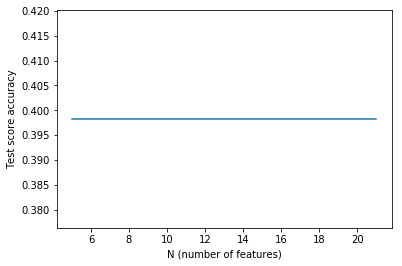

In [106]:
# Plot test accuracy for each model with N features selected from RFE method

plt.plot(range(min_features, max_features+1), test_acc)
plt.xlabel('N (number of features)')
plt.ylabel('Test score accuracy')

print("Number of features in model with maximum test accuracy: {}".format(min_features+test_acc.index(max(test_acc))))

print("Accuracy on training set: {:.3f}".format(selector.score(X_train_sim, y_train_sim)))
print("Accuracy on training set: {:.3f}".format(selector.score(X_test_sim, y_test_sim)))

print(selector.predict(X_test_sim)[0:20])

### Model 2: Neural Network

In [107]:
import sklearn
from sklearn.neural_network import MLPClassifier
print("scikit-learn version: {}".format(sklearn.__version__))
from sklearn.model_selection import train_test_split
import mglearn

scikit-learn version: 0.19.1


<b> Generic MLPClassifer with 10-genre categorization </b>

In [108]:
mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.36
Accuracy on test set: 0.20
Sample output:['romance' 'horror' 'horror' 'science_fiction' 'horror' 'horror' 'horror'
 'horror' 'horror' 'drama' 'science_fiction' 'science_fiction' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'science_fiction']


In [109]:
mlp = MLPClassifier(solver='lbfgs', activation='tanh',
random_state=0, hidden_layer_sizes=[100, 100]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.50
Accuracy on test set: 0.18
Sample output:['romance' 'horror' 'science_fiction' 'horror' 'horror' 'action' 'drama'
 'family' 'romance' 'comedy' 'drama' 'horror' 'horror' 'romance' 'romance'
 'drama' 'drama' 'horror' 'horror' 'horror']


In [110]:
mlp = MLPClassifier(solver='lbfgs', activation='tanh',
random_state=0, hidden_layer_sizes=[10, 100]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.28
Accuracy on test set: 0.24
Sample output:['horror' 'horror' 'family' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'drama' 'crime' 'science_fiction' 'horror' 'horror' 'horror'
 'crime' 'horror' 'horror' 'horror' 'science_fiction']


In [111]:
mlp = MLPClassifier(solver='adam', activation='tanh',
random_state=5, hidden_layer_sizes=[10, 10], max_iter=2000).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.25
Accuracy on test set: 0.27
Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror']


In [112]:
mlp = MLPClassifier(solver='lbfgs', activation='relu',
random_state=0, hidden_layer_sizes=[10, 10]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.25
Accuracy on test set: 0.25
Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'adventure' 'horror'
 'horror' 'horror' 'drama' 'horror' 'horror' 'horror' 'horror' 'horror'
 'adventure' 'horror' 'horror' 'horror' 'horror']


In [113]:
mlp = MLPClassifier(activation='identity',solver='sgd', 
random_state=0, max_iter=1000, hidden_layer_sizes=[3, 110]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.25
Accuracy on test set: 0.27
Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror']


In [114]:
mlp = MLPClassifier(activation='identity',solver='sgd', 
random_state=0, max_iter=1000, hidden_layer_sizes=[10, 1000]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.25
Accuracy on test set: 0.27
Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror']


In [115]:
mlp = MLPClassifier(activation='logistic',solver='sgd', 
random_state=0, max_iter=1000, hidden_layer_sizes=[10, 1000]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.25
Accuracy on test set: 0.27
Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror']


In [116]:
mlp = MLPClassifier(activation='logistic',solver='sgd', 
random_state=4, max_iter=1000, hidden_layer_sizes=[100, 1000]).fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

print("Sample output:{}".format(mlp.predict(X_test)[0:20]))

Accuracy on training set: 0.25
Accuracy on test set: 0.27
Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror']


<b>Testing the performance of MLPClassifier on the "Simple Genre" categorization datasest </b>

In [117]:
mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.57
Accuracy on test set: 0.42
Sample output:['RFC' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC' 'horror'
 'other' 'other' 'other' 'other' 'horror' 'other' 'other' 'other' 'RFC'
 'other' 'other']


In [118]:
mlp = MLPClassifier(solver='lbfgs', activation='tanh',
random_state=0, hidden_layer_sizes=[100, 100]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.59
Accuracy on test set: 0.41
Sample output:['other' 'horror' 'other' 'RFC' 'other' 'other' 'other' 'other' 'horror'
 'horror' 'other' 'other' 'other' 'horror' 'other' 'other' 'other' 'RFC'
 'other' 'other']


In [119]:
mlp = MLPClassifier(solver='lbfgs', activation='tanh',
random_state=0, hidden_layer_sizes=[10, 100]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.54
Accuracy on test set: 0.41
Sample output:['other' 'horror' 'other' 'RFC' 'other' 'other' 'other' 'other' 'horror'
 'other' 'other' 'horror' 'other' 'horror' 'other' 'other' 'other'
 'horror' 'other' 'other']


In [120]:
mlp = MLPClassifier(solver='adam', activation='tanh',
random_state=5, hidden_layer_sizes=[10, 10], max_iter=2000).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.46
Accuracy on test set: 0.38
Sample output:['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other']


In [121]:
mlp = MLPClassifier(solver='lbfgs', activation='relu',
random_state=0, hidden_layer_sizes=[10, 10]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.57
Accuracy on test set: 0.42
Sample output:['RFC' 'horror' 'other' 'RFC' 'horror' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'other' 'other' 'horror' 'other' 'other' 'RFC' 'RFC'
 'other' 'other']


In [122]:
mlp = MLPClassifier(activation='identity',solver='sgd', 
random_state=0, max_iter=1000, hidden_layer_sizes=[3, 110]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.46
Accuracy on test set: 0.40
Sample output:['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other']


In [123]:
mlp = MLPClassifier(activation='identity',solver='sgd', 
random_state=0, max_iter=1000, hidden_layer_sizes=[10, 1000]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.46
Accuracy on test set: 0.40
Sample output:['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other']


In [124]:
mlp = MLPClassifier(activation='logistic',solver='sgd', 
random_state=0, max_iter=1000, hidden_layer_sizes=[10, 1000]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.46
Accuracy on test set: 0.40
Sample output:['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other']


In [125]:
mlp = MLPClassifier(activation='logistic',solver='sgd', 
random_state=4, max_iter=1000, hidden_layer_sizes=[100, 1000]).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.46
Accuracy on test set: 0.40
Sample output:['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other']


<b> Accuracy by Class for Highest Scoring Non-Trivial Simple-Genre Classifer (NNET) </b>

As seen from above, many of the MLPClassifiers obtain their highest accuracy simply by predicting the most common target variable value ("Horror") for all inputs (i.e. a constant output classifier). This is not ideal, because it does not give us any information about how the inputs relate to the target variable.

Therefore, we will also further explore the highest-accuracy scoring model (out of the simple-genre, i.e. 3-category target variable) that is non-trivial, i.e. not only predicting 'Horror' to understand its classification accuracy for each class ("Horror", "RFC", "Other").

In [165]:
# This was the highest test-set accuracy scoring simple-genre model from above:

mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train_sim, y_train_sim)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_sim, y_test_sim)))

print("Sample output:{}".format(mlp.predict(X_test_sim)[0:20]))

Accuracy on training set: 0.57
Accuracy on test set: 0.42
Sample output:['RFC' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC' 'horror'
 'other' 'other' 'other' 'other' 'horror' 'other' 'other' 'other' 'RFC'
 'other' 'other']


In [166]:
# Check accuracy of model by each individual class

X_horror = pd.DataFrame(X_test_sim)[y_test_sim=='horror']
X_RFC = pd.DataFrame(X_test_sim)[y_test_sim=='RFC']
X_other = pd.DataFrame(X_test_sim)[y_test_sim=='other']

y_pred = mlp.predict(X_test_sim)

print("Ratio of Horror class in test set: {:.2f}".format(np.sum(y_test_sim=='horror')/len(X_test_sim)))
print("Ratio of RFC class in test set: {:.2f}".format(np.sum(y_test_sim=='RFC')/len(X_test_sim)))
print("Ratio of other class in test set: {:.2f}".format(np.sum(y_test_sim=='other')/len(X_test_sim)))
print('\n')

print("Ratio of Horror class predictions: {:.2f}".format(np.sum(y_pred=='horror')/len(y_test)))
print("Ratio of RFC class predictions: {:.2f}".format(np.sum(y_pred=='RFC')/len(y_test)))
print("Ratio of other class predictions: {:.2f}".format(np.sum(y_pred=='other')/len(y_test)))
print('\n')

print("Prediction accuracy for Horror class: {:.2f}".format(np.sum(mlp.predict(X_horror)=='horror')/len(X_horror)))
print("Prediction accuracy for RFC class: {:.2f}".format(np.sum(mlp.predict(X_RFC)=='RFC')/len(X_RFC)))
print("Prediction accuracy for other class: {:.2f}".format(np.sum(mlp.predict(X_other)=='other')/len(X_other)))

Ratio of Horror class in test set: 0.27
Ratio of RFC class in test set: 0.34
Ratio of other class in test set: 0.40


Ratio of Horror class predictions: 0.22
Ratio of RFC class predictions: 0.27
Ratio of other class predictions: 0.50


Prediction accuracy for Horror class: 0.33
Prediction accuracy for RFC class: 0.26
Prediction accuracy for other class: 0.60


### Model 3: K-Nearest Neighbors (KNN)

First we will train and test our first kNN model using an arbitrary k value. We will then fine tune k using cross-validation. This first model utilizes all possible input variables and all ten genre classifications.

In [128]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [129]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [130]:
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

In [131]:
print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test)))

kNN Prediction Accuracy on Training Set: 0.36
kNN Prediction Accuracy on Test Set: 0.18


<b> Hyperparameter Tuning with Cross-validation for k </b>

To tune the hyperparameter k we will use cross_val_score. We begin the hyperparameter tuning by creating a list of odd numbers from 1 to 100 which represent possible k values that we could choose from. We then use cross_val_score to load the average test scores from the each of the ten trials for each iteration of k (odd numbers from 1-100) into a different empty list cv_scores.

In [132]:
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

Then we optimize our k value by minimizing the misclassification error of our model. This is done by choosing the lowest k value that corresponds to the lowest average misclassification error. We print a graph of the Number of neighbors k versus the error to demonstrate the minimum.

The optimal number of neighbors is 85


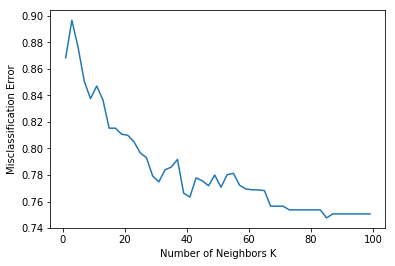

In [133]:
# changing to misclassification error
import matplotlib.pyplot as plt
MSE =[1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.show()

Now we recreate the kNN model using 81 nearest neighbors and test again.

In [164]:
knn = KNeighborsClassifier(n_neighbors=85)
knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.25
kNN Prediction Accuracy on Test Set: 0.26


Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror']


Next we will train and test a new kNN model using the simple target variable set which only has three different classifications instead of ten.

In [135]:
knn_sim = KNeighborsClassifier(n_neighbors=1)
knn_sim.fit(X_train_sim, y_train_sim)

y_pred_train = knn_sim.predict(X_train_sim)
y_pred_test = knn_sim.predict(X_test_sim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_sim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_sim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 1.00
kNN Prediction Accuracy on Test Set: 0.35


Sample output:['RFC' 'other' 'other' 'horror' 'horror' 'horror' 'RFC' 'horror' 'other'
 'other' 'other' 'RFC' 'RFC' 'horror' 'other' 'other' 'RFC' 'horror'
 'horror' 'other' 'other' 'other' 'RFC' 'other' 'RFC' 'other' 'other'
 'horror' 'horror' 'other']


Fine tune k using cross-fold validation.

The optimal number of neighbors is 71


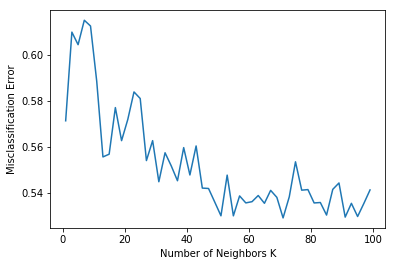

In [136]:
# creating odd list of K for KNN
myList = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_sim, y_train_sim, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
import matplotlib.pyplot as plt
MSE =[1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.show()

In [137]:
knn_sim = KNeighborsClassifier(n_neighbors=33)
knn_sim.fit(X_train_sim, y_train_sim)

y_pred_train = knn_sim.predict(X_train_sim)
y_pred_test = knn_sim.predict(X_test_sim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_sim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_sim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.48
kNN Prediction Accuracy on Test Set: 0.43


Sample output:['RFC' 'other' 'RFC' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'horror' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'RFC' 'other' 'other']


Next we will create kNN models for both the ten class target set and the 3 class target set with different sets of predictor variables. First we train a model using only our binary month variables, then we train a model using all of our predictor variables except for the binary monthy indicators. WE do this to test the correlation of our predictions to our socio-economic and socio-political predictors versus the time of year.

In [138]:
#kNN model with only month predictors
knn_mo = KNeighborsClassifier(n_neighbors=5)
knn_mo.fit(X_train_mo, y_train_mo)

y_pred_train = knn_mo.predict(X_train_mo)
y_pred_test = knn_mo.predict(X_test_mo)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_mo)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_mo)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.20
kNN Prediction Accuracy on Test Set: 0.16


Sample output:['adventure' 'action' 'romance' 'action' 'horror' 'action' 'horror'
 'romance' 'horror' 'romance' 'horror' 'comedy' 'romance' 'horror'
 'action' 'comedy' 'horror' 'romance' 'romance' 'adventure' 'romance'
 'horror' 'romance' 'horror' 'romance' 'romance' 'comedy' 'horror'
 'horror' 'romance']


The optimal number of neighbors is 79


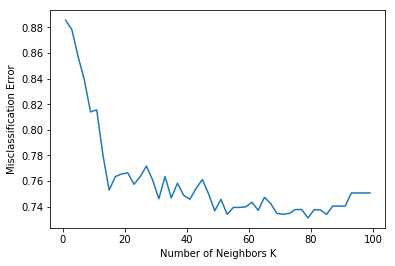

In [139]:
# creating odd list of K for KNN
myList = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_mo, y_train_mo, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
import matplotlib.pyplot as plt
MSE =[1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.show()

kNN model with only month predictors with k fine tuned using cross validation.


In [140]:
knn_mo = KNeighborsClassifier(n_neighbors=79)
knn_mo.fit(X_train_mo, y_train_mo)

y_pred_train = knn_mo.predict(X_train_mo)
y_pred_test = knn_mo.predict(X_test_mo)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_mo)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_mo)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.26
kNN Prediction Accuracy on Test Set: 0.25


Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'romance' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror']


kNN model using only socio-economic and socio-political variables.

In [141]:
knn_nomo = KNeighborsClassifier(n_neighbors=1)
knn_nomo.fit(X_train_nomo, y_train_nomo)

y_pred_train = knn_nomo.predict(X_train_nomo)
y_pred_test = knn_nomo.predict(X_test_nomo)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_nomo)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_nomo)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 1.00
kNN Prediction Accuracy on Test Set: 0.13


Sample output:['romance' 'adventure' 'science_fiction' 'horror' 'horror' 'horror'
 'romance' 'horror' 'science_fiction' 'action' 'science_fiction' 'family'
 'family' 'horror' 'science_fiction' 'drama' 'family' 'horror' 'horror'
 'thriller' 'science_fiction' 'crime' 'comedy' 'adventure' 'romance'
 'crime' 'drama' 'horror' 'horror' 'action']


The optimal number of neighbors is 85


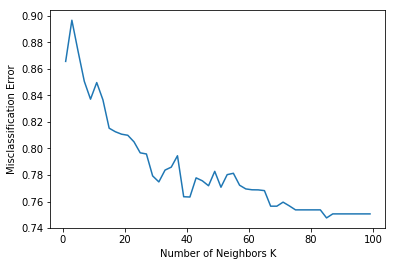

In [142]:
# creating odd list of K for KNN
myList = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_nomo, y_train_nomo, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
import matplotlib.pyplot as plt
MSE =[1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.show()

kNN model using only socio-economic and socio-political variables with fine tuned k.

In [143]:
knn_nomo = KNeighborsClassifier(n_neighbors=81)
knn_nomo.fit(X_train_nomo, y_train_nomo)

y_pred_train = knn_nomo.predict(X_train_nomo)
y_pred_test = knn_nomo.predict(X_test_nomo)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_nomo)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_nomo)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.25
kNN Prediction Accuracy on Test Set: 0.26


Sample output:['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror']


kNN model with three class classification using only month predictors and simple genre target set.

In [144]:
knn_msim = KNeighborsClassifier(n_neighbors=1)
knn_msim.fit(X_train_msim, y_train_msim)

y_pred_train = knn_msim.predict(X_train_msim)
y_pred_test = knn_msim.predict(X_test_msim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_msim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_msim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.35
kNN Prediction Accuracy on Test Set: 0.28


Sample output:['RFC' 'other' 'horror' 'other' 'horror' 'other' 'other' 'other' 'horror'
 'other' 'other' 'RFC' 'RFC' 'horror' 'other' 'RFC' 'horror' 'RFC'
 'horror' 'RFC' 'other' 'other' 'RFC' 'horror' 'horror' 'RFC' 'RFC'
 'horror' 'horror' 'other']


The optimal number of neighbors is 67


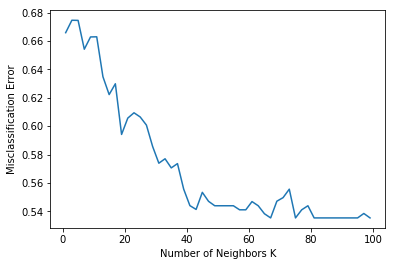

In [145]:
# creating odd list of K for KNN
myList = list(range(1,100))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_msim, y_train_msim, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
import matplotlib.pyplot as plt
MSE =[1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.show()

In [146]:
knn_msim = KNeighborsClassifier(n_neighbors=67)
knn_msim.fit(X_train_msim, y_train_msim)

y_pred_train = knn_msim.predict(X_train_msim)
y_pred_test = knn_msim.predict(X_test_msim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_msim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_msim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.46
kNN Prediction Accuracy on Test Set: 0.40


Sample output:['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other']


kNN model with three class classification using only socio-economic and socio-political predictors and simple genre target set.

In [147]:
knn_nmsim = KNeighborsClassifier(n_neighbors=1)
knn_nmsim.fit(X_train_nmsim, y_train_nmsim)

y_pred_train = knn_nmsim.predict(X_train_nmsim)
y_pred_test = knn_nmsim.predict(X_test_nmsim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_nmsim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_nmsim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 1.00
kNN Prediction Accuracy on Test Set: 0.36


Sample output:['RFC' 'other' 'other' 'horror' 'horror' 'horror' 'RFC' 'horror' 'other'
 'other' 'other' 'RFC' 'RFC' 'horror' 'other' 'other' 'RFC' 'horror'
 'horror' 'other' 'other' 'other' 'RFC' 'other' 'RFC' 'other' 'other'
 'horror' 'horror' 'other']


The optimal number of neighbors is 49


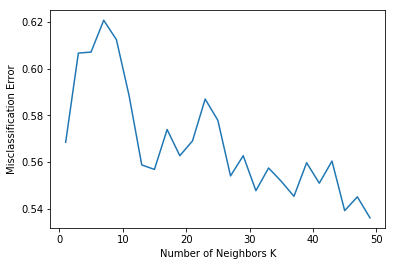

In [148]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_nmsim, y_train_nmsim, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
import matplotlib.pyplot as plt
MSE =[1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

plt.show()

In [167]:
knn_nmsim = KNeighborsClassifier(n_neighbors=49)
knn_nmsim.fit(X_train_nmsim, y_train_nmsim)

y_pred_train = knn_nmsim.predict(X_train_nmsim)
y_pred_test = knn_nmsim.predict(X_test_nmsim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_nmsim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_nmsim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.49
kNN Prediction Accuracy on Test Set: 0.41


Sample output:['RFC' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'RFC' 'other' 'other']


<b> Accuracy by Class for Highest Scoring Non-Trivial Simple-Genre Classifer (KNN) </b>

In [168]:
# This was the highest test-set accuracy scoring simple-genre model from above:

knn_nmsim = KNeighborsClassifier(n_neighbors=49)
knn_nmsim.fit(X_train_nmsim, y_train_nmsim)

y_pred_train = knn_nmsim.predict(X_train_nmsim)
y_pred_test = knn_nmsim.predict(X_test_nmsim)

print("kNN Prediction Accuracy on Training Set: {:.2f}".format(np.mean(y_pred_train == y_train_nmsim)))
print("kNN Prediction Accuracy on Test Set: {:.2f}".format(np.mean(y_pred_test == y_test_nmsim)))
print("\n")
print("Sample output:{}".format(y_pred_test[0:30]))

kNN Prediction Accuracy on Training Set: 0.49
kNN Prediction Accuracy on Test Set: 0.41


Sample output:['RFC' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'RFC' 'other' 'other']


In [151]:
# Check accuracy of model by each individual class

X_horror = pd.DataFrame(X_test_nmsim)[y_test_nmsim=='horror']
X_RFC = pd.DataFrame(X_test_nmsim)[y_test_nmsim=='RFC']
X_other = pd.DataFrame(X_test_nmsim)[y_test_nmsim=='other']

y_pred = knn_nmsim.predict(X_test_nmsim)

print("Ratio of Horror class in test set: {:.2f}".format(np.sum(y_test_nmsim=='horror')/len(X_test_nmsim)))
print("Ratio of RFC class in test set: {:.2f}".format(np.sum(y_test_nmsim=='RFC')/len(X_test_nmsim)))
print("Ratio of other class in test set: {:.2f}".format(np.sum(y_test_nmsim=='other')/len(X_test_nmsim)))
print('\n')

print("Ratio of Horror class predictions: {:.2f}".format(np.sum(y_pred=='horror')/len(y_test_nmsim)))
print("Ratio of RFC class predictions: {:.2f}".format(np.sum(y_pred=='RFC')/len(y_test_nmsim)))
print("Ratio of other class predictions: {:.2f}".format(np.sum(y_pred=='other')/len(y_test_nmsim)))
print('\n')

print("Prediction accuracy for Horror class: {:.2f}".format(np.sum(knn_nmsim.predict(X_horror)=='horror')/len(X_horror)))
print("Prediction accuracy for RFC class: {:.2f}".format(np.sum(knn_nmsim.predict(X_RFC)=='RFC')/len(X_RFC)))
print("Prediction accuracy for other class: {:.2f}".format(np.sum(knn_nmsim.predict(X_other)=='other')/len(X_other)))

Ratio of Horror class in test set: 0.27
Ratio of RFC class in test set: 0.34
Ratio of other class in test set: 0.40


Ratio of Horror class predictions: 0.04
Ratio of RFC class predictions: 0.27
Ratio of other class predictions: 0.70


Prediction accuracy for Horror class: 0.03
Prediction accuracy for RFC class: 0.32
Prediction accuracy for other class: 0.80


### Model 4: Decision Trees

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz 

dt = DecisionTreeClassifier(random_state=0)

dt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(dt.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test,y_test)))

# export_graphviz(dt, out_file="tree.dot", impurity=False, filled=True) 

# import graphviz
# with open("tree.dot") as f:    
#     dot_graph = f.read() 
#     display(graphviz.Source(dot_graph))

Accuracy on training set: 1.000
Accuracy on test set: 0.097


The above results are a sign of extreme over-fitting. Will use <b>GridSearchCV</b> method to test across a range of combinations of DT parameters, and select the "best" model based on 5-fold CV score. 

In [153]:
from sklearn.model_selection import GridSearchCV

criterion = ['gini', 'entropy']
max_depth = list(range(5,21))
min_samples_leaf = list(range(1,50))

param_grid = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

grid = GridSearchCV(estimator=dt, param_grid=param_grid)

grid_result = grid.fit(X_train, y_train)

print(grid_result.best_params_)
print("\n")

print("Accuracy on training set: {:.3f}".format(grid_result.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(grid_result.score(X_test, y_test)))
print("\n")

print("Sample output: {}".format(grid_result.predict(X_test)[0:30]))

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 42}


Accuracy on training set: 0.269
Accuracy on test set: 0.248


Sample output: ['horror' 'horror' 'horror' 'horror' 'crime' 'horror' 'crime' 'family'
 'horror' 'horror' 'family' 'horror' 'horror' 'horror' 'horror' 'crime'
 'horror' 'horror' 'horror' 'horror' 'crime' 'horror' 'family' 'horror'
 'family' 'horror' 'crime' 'horror' 'horror' 'horror']


In [154]:
set(grid_result.predict(X_test))

{'crime', 'family', 'horror'}

The above result shows that the optimal decision tree (using entropy as loss criterion, max depth = 5, minimum samples per left = 41) is only predicting 3 out of the 10 possible classes - action, horror, or romance.

Still, the prediction accuracy on the test set (28.3%) is better than for other model types we have seen. To investigate further how the model is performing, will do a class-by-class accuracy analysis:

In [155]:
X_action = pd.DataFrame(X_test)[y_test=='action']
X_horror = pd.DataFrame(X_test)[y_test=='horror']
X_romance = pd.DataFrame(X_test)[y_test=='romance']

y_pred_action = grid_result.predict(X_action)
y_pred_horror = grid_result.predict(X_horror)
y_pred_romance = grid_result.predict(X_romance)

tot_action = np.sum(grid_result.predict(X_test)=='action')
tot_horror = np.sum(grid_result.predict(X_test)=='horror')
tot_romance = np.sum(grid_result.predict(X_test)=='romance')


print("Ratio of Action class in test set: {:.2f}".format(np.sum(y_test=='action')/len(X_test)))
print("Ratio of Horror class in test set: {:.2f}".format(np.sum(y_test=='horror')/len(X_test)))
print("Ratio of Romance class in test set: {:.2f}".format(np.sum(y_test=='romance')/len(X_test)))
print('\n')

print("Ratio of Action class predictions: {:.2f}".format(tot_action/len(X_test)))
print("Ratio of Horror class predictions: {:.2f}".format(tot_horror/len(X_test)))
print("Ratio of Romance class predictions: {:.2f}".format(tot_romance/len(X_test)))
print('\n')

print("Prediction accuracy for Action class: {:.2f}".format(np.sum(y_pred_action=='action')/len(X_action)))
print("Prediction accuracy for Horror class: {:.2f}".format(np.sum(y_pred_horror=='horror')/len(X_horror)))
print("Prediction accuracy for Romance class: {:.2f}".format(np.sum(y_pred_romance=='romance')/len(X_romance)))

Ratio of Action class in test set: 0.05
Ratio of Horror class in test set: 0.27
Ratio of Romance class in test set: 0.12


Ratio of Action class predictions: 0.00
Ratio of Horror class predictions: 0.77
Ratio of Romance class predictions: 0.00


Prediction accuracy for Action class: 0.00
Prediction accuracy for Horror class: 0.93
Prediction accuracy for Romance class: 0.00


<b>Repeating the same procedure as above for the Simple Genre dataset (three target labels).  </b>

In [156]:
dt_sim = DecisionTreeClassifier()

from sklearn.model_selection import GridSearchCV

criterion = ['gini', 'entropy']
max_depth = list(range(5,21))
min_samples_leaf = list(range(1,50))

param_grid = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

grid = GridSearchCV(estimator=dt_sim, param_grid=param_grid)

grid_result = grid.fit(X_train_sim, y_train_sim)

print(grid_result.best_params_)
print("\n")

print("Accuracy on training set: {:.3f}".format(grid_result.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.3f}".format(grid_result.score(X_test_sim, y_test_sim)))
print("\n")

print("Sample output: {}".format(grid_result.predict(X_test_sim)[0:30]))

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 43}


Accuracy on training set: 0.497
Accuracy on test set: 0.451


Sample output: ['RFC' 'other' 'horror' 'horror' 'other' 'other' 'other' 'other' 'RFC'
 'other' 'other' 'horror' 'other' 'horror' 'RFC' 'other' 'other' 'RFC'
 'horror' 'other' 'other' 'other' 'other' 'other' 'other' 'RFC' 'other'
 'horror' 'other' 'horror']


In [157]:
# Check accuracy of model by each individual class

X_horror = pd.DataFrame(X_test_sim)[y_test_sim=='horror']
X_RFC = pd.DataFrame(X_test_sim)[y_test_sim=='RFC']
X_other = pd.DataFrame(X_test_sim)[y_test_sim=='other']

y_pred = grid_result.predict(X_test_sim)

print("Ratio of Horror class in test set: {:.2f}".format(np.sum(y_test_sim=='horror')/len(X_test_sim)))
print("Ratio of RFC class in test set: {:.2f}".format(np.sum(y_test_sim=='RFC')/len(X_test_sim)))
print("Ratio of other class in test set: {:.2f}".format(np.sum(y_test_sim=='other')/len(X_test_sim)))
print('\n')

print("Ratio of Horror class predictions: {:.2f}".format(np.sum(y_pred=='horror')/len(y_test_sim)))
print("Ratio of RFC class predictions: {:.2f}".format(np.sum(y_pred=='RFC')/len(y_test_sim)))
print("Ratio of other class predictions: {:.2f}".format(np.sum(y_pred=='other')/len(y_test_sim)))
print('\n')

print("Prediction accuracy for Horror class: {:.2f}".format(np.sum(grid_result.predict(X_horror)=='horror')/len(X_horror)))
print("Prediction accuracy for RFC class: {:.2f}".format(np.sum(grid_result.predict(X_RFC)=='RFC')/len(X_RFC)))
print("Prediction accuracy for other class: {:.2f}".format(np.sum(grid_result.predict(X_other)=='other')/len(X_other)))

Ratio of Horror class in test set: 0.27
Ratio of RFC class in test set: 0.34
Ratio of other class in test set: 0.40


Ratio of Horror class predictions: 0.29
Ratio of RFC class predictions: 0.17
Ratio of other class predictions: 0.54


Prediction accuracy for Horror class: 0.43
Prediction accuracy for RFC class: 0.24
Prediction accuracy for other class: 0.64


### Model 5: Logistic Regression Classifier

In [158]:
# 10-genre classifier 

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test, y_test)))
print("\n")
logreg = LogisticRegression(C=100).fit(X_train, y_train) #Best of this set
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test, y_test)))
print("Sample output: {}".format(logreg.predict(X_test)[0:30]))
print("\n")
logreg = LogisticRegression(C=.01).fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test, y_test)))
print("\n")

# "Simple" classifier

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_sim, y_train_sim)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test, y_test)))
print("\n")
logreg = LogisticRegression(C=100).fit(X_train_sim, y_train_sim)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test, y_test)))
print("\n")
logreg = LogisticRegression(C=.01).fit(X_train_sim, y_train_sim) #Best of this set
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_sim, y_test_sim)))
print("Sample output: {}".format(logreg.predict(X_test)[0:30]))
print("\n")
# Trying month/year seperated sets, 10-genre and Simple

# _mo
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_mo, y_train_mo) 
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_mo, y_train_mo)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_mo, y_test_mo)))
print("\n")
logreg = LogisticRegression(C=100).fit(X_train_mo, y_train_mo)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_mo, y_train_mo)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_mo, y_test_mo)))
print("\n")
logreg = LogisticRegression(C=.01).fit(X_train_mo, y_train_mo) #Best of this set
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_mo, y_train_mo)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_mo, y_test_mo)))
print("Sample output: {}".format(logreg.predict(X_test_mo)[0:30]))
print("\n")

# _nomo
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_nomo, y_train_nomo) #Tied for best
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nomo, y_train_nomo)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nomo, y_test_nomo)))
print("\n")
logreg = LogisticRegression(C=100).fit(X_train_nomo, y_train_nomo)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nomo, y_train_nomo)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nomo, y_test_nomo)))
print("\n")
logreg = LogisticRegression(C=.01).fit(X_train_nomo, y_train_nomo) #Tied for best
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nomo, y_train_nomo)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nomo, y_test_nomo)))
print("Sample output: {}".format(logreg.predict(X_test_nomo)[0:30]))
print("\n")

# _msim
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_msim, y_train_msim)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_msim, y_train_msim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_msim, y_test_msim)))
print("\n")
logreg = LogisticRegression(C=100).fit(X_train_msim, y_train_msim)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_msim, y_train_msim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_msim, y_test_msim)))
print("\n")
logreg = LogisticRegression(C=.01).fit(X_train_msim, y_train_msim) #Best of this set
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_msim, y_train_msim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_msim, y_test_msim)))
print("Sample output: {}".format(logreg.predict(X_test_msim)[0:30]))
print("\n")

# _nmsim
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_nmsim, y_train_nmsim)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nmsim, y_train_nmsim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nmsim, y_test_nmsim)))
print("\n")
logreg = LogisticRegression(C=100).fit(X_train_nmsim, y_train_nmsim) #Best of this set
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nmsim, y_train_nmsim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nmsim, y_test_nmsim)))
print("Sample output: {}".format(logreg.predict(X_test_nmsim)[0:30]))
print("\n")
logreg = LogisticRegression(C=.01).fit(X_train_nmsim, y_train_nmsim)
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nmsim, y_train_nmsim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nmsim, y_test_nmsim)))
print("\n")

Accuracy on training set: 0.251
Accuracy on test set: 0.265


Accuracy on training set: 0.340
Accuracy on test set: 0.221
Sample output: ['romance' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'drama' 'horror' 'horror' 'horror' 'horror' 'horror' 'drama'
 'horror' 'horror' 'horror' 'science_fiction' 'drama' 'horror' 'romance'
 'horror' 'crime' 'horror' 'drama' 'horror' 'horror' 'horror']


Accuracy on training set: 0.249
Accuracy on test set: 0.265


Accuracy on training set: 0.062
Accuracy on test set: 0.035


Accuracy on training set: 0.118
Accuracy on test set: 0.088


Accuracy on training set: 0.464
Accuracy on test set: 0.398
Sample output: ['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other']


Accuracy on training set: 0.272
Accuracy on test set: 0.212


Accuracy o

<b> Accuracy by Class for Highest Scoring Non-Trivial Classifier (LR) for Simple Genre </b>

This is the model which yielded the highest test set accuracy from above (for logistic regression). To evaluate further, will display test set accuracy by class:

In [159]:
logreg = LogisticRegression(C=100).fit(X_train_nmsim, y_train_nmsim) #Best of this set
print("Accuracy on training set: {:.3f}".format(logreg.score(X_train_nmsim, y_train_nmsim)))
print("Accuracy on test set: {:.3f}".format(logreg.score(X_test_nmsim, y_test_nmsim)))

Accuracy on training set: 0.479
Accuracy on test set: 0.425


In [160]:
# Check accuracy of model by each individual class

X_horror = pd.DataFrame(X_test_nmsim)[y_test_nmsim=='horror']
X_RFC = pd.DataFrame(X_test_nmsim)[y_test_nmsim=='RFC']
X_other = pd.DataFrame(X_test_nmsim)[y_test_nmsim=='other']

y_pred = logreg.predict(X_test_nmsim)

print("Ratio of Horror class in test set: {:.2f}".format(np.sum(y_test_nmsim=='horror')/len(X_test_nmsim)))
print("Ratio of RFC class in test set: {:.2f}".format(np.sum(y_test_nmsim=='RFC')/len(X_test_nmsim)))
print("Ratio of other class in test set: {:.2f}".format(np.sum(y_test_nmsim=='other')/len(X_test_nmsim)))
print('\n')

print("Ratio of Horror class predictions: {:.2f}".format(np.sum(y_pred=='horror')/len(y_test_nmsim)))
print("Ratio of RFC class predictions: {:.2f}".format(np.sum(y_pred=='RFC')/len(y_test_nmsim)))
print("Ratio of other class predictions: {:.2f}".format(np.sum(y_pred=='other')/len(y_test_nmsim)))
print('\n')

print("Prediction accuracy for Horror class: {:.2f}".format(np.sum(logreg.predict(X_horror)=='horror')/len(X_horror)))
print("Prediction accuracy for RFC class: {:.2f}".format(np.sum(logreg.predict(X_RFC)=='RFC')/len(X_RFC)))
print("Prediction accuracy for other class: {:.2f}".format(np.sum(logreg.predict(X_other)=='other')/len(X_other)))

Ratio of Horror class in test set: 0.27
Ratio of RFC class in test set: 0.34
Ratio of other class in test set: 0.40


Ratio of Horror class predictions: 0.12
Ratio of RFC class predictions: 0.18
Ratio of other class predictions: 0.70


Prediction accuracy for Horror class: 0.10
Prediction accuracy for RFC class: 0.24
Prediction accuracy for other class: 0.80


### Model 6: Support Vector Machines (SVMs)

Similar to the process for Decision Trees, using GridSearchCV below to search for optimal combination of hyperparameters from a range of combinations. 

In [161]:
from sklearn.svm import SVC

svm = SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
degree = [2,3,4,5,6]

param_grid = dict(C=C, degree=degree, kernel=kernel)

grid = GridSearchCV(estimator=svm, param_grid=param_grid)

grid_result = grid.fit(X_train, y_train)

print(grid_result.best_params_)
print("\n")

print("Accuracy on training set: {:.3f}".format(grid_result.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(grid_result.score(X_test, y_test)))
print("\n")

print("Sample output: {}".format(grid_result.predict(X_test)[0:30]))

{'C': 0.001, 'degree': 2, 'kernel': 'linear'}


Accuracy on training set: 0.249
Accuracy on test set: 0.265


Sample output: ['horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror' 'horror'
 'horror' 'horror' 'horror' 'horror' 'horror' 'horror']


The above model is predicting mostly 'Horror', but still outputs other target labels as well. 

<b>Testing the performance ofSVM on the "Simple Genre" categorization datasest </b>

In [162]:
from sklearn.svm import SVC

svm = SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
degree = [2,3,4,5,6]

param_grid = dict(C=C, degree=degree, kernel=kernel)

grid = GridSearchCV(estimator=svm, param_grid=param_grid)

grid_result = grid.fit(X_train_sim, y_train_sim)

print(grid_result.best_params_)
print("\n")

print("Accuracy on training set: {:.3f}".format(grid_result.score(X_train_sim, y_train_sim)))
print("Accuracy on test set: {:.3f}".format(grid_result.score(X_test_sim, y_test_sim)))
print("\n")

print("Sample output: {}".format(grid_result.predict(X_test_sim)[0:30]))

{'C': 0.001, 'degree': 2, 'kernel': 'linear'}


Accuracy on training set: 0.464
Accuracy on test set: 0.398


Sample output: ['other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other' 'other'
 'other' 'other' 'other']


In [163]:
# Check accuracy of model by each individual class for Simple Genre model

X_horror = pd.DataFrame(X_test_sim)[y_test_sim=='horror']
X_RFC = pd.DataFrame(X_test_sim)[y_test_sim=='RFC']
X_other = pd.DataFrame(X_test_sim)[y_test_sim=='other']

svm = SVC(C=100, degree=2, kernel='rbf')

svm.fit(X_train_sim, y_train_sim)

y_pred = svm.predict(X_test_sim)

print("Ratio of Horror class in test set: {:.2f}".format(np.sum(y_test_sim=='horror')/len(X_test_sim)))
print("Ratio of RFC class in test set: {:.2f}".format(np.sum(y_test_sim=='RFC')/len(X_test_sim)))
print("Ratio of other class in test set: {:.2f}".format(np.sum(y_test_sim=='other')/len(X_test_sim)))
print('\n')

print("Ratio of Horror class predictions: {:.2f}".format(np.sum(y_pred=='horror')/len(y_test)))
print("Ratio of RFC class predictions: {:.2f}".format(np.sum(y_pred=='RFC')/len(y_test)))
print("Ratio of other class predictions: {:.2f}".format(np.sum(y_pred=='other')/len(y_test)))
print('\n')

print("Prediction accuracy for Horror class: {:.2f}".format(np.sum(svm.predict(X_horror)=='horror')/len(X_horror)))
print("Prediction accuracy for RFC class: {:.2f}".format(np.sum(svm.predict(X_RFC)=='RFC')/len(X_RFC)))
print("Prediction accuracy for other class: {:.2f}".format(np.sum(svm.predict(X_other)=='other')/len(X_other)))

Ratio of Horror class in test set: 0.27
Ratio of RFC class in test set: 0.34
Ratio of other class in test set: 0.40


Ratio of Horror class predictions: 0.01
Ratio of RFC class predictions: 0.00
Ratio of other class predictions: 0.99


Prediction accuracy for Horror class: 0.00
Prediction accuracy for RFC class: 0.00
Prediction accuracy for other class: 1.00
